# Imports

In [55]:
try:
        
    import h5py
    
    from ipywidgets import widgets, Layout, interact, interactive, interactive_output, Dropdown
    from IPython.display import display
    import bqplot as bqp
    from bqplot import pyplot as plt # bqplot is a plotting for jupyter
    import matplotlib.pyplot as mplt
    import numpy as np
    import random
    import seaborn as sns 
    import pandas as pd
    import graphing as gr
    #!pip install viola
    ########## Modules required for artist drawing on matplotlib
    import matplotlib.path as mpath
    import matplotlib.lines as mlines
    import matplotlib.patches as mpatches
    from matplotlib.collections import PatchCollection
    
      
except ModuleNotFoundError:
        print("A class you are trying to import is not present in the directory")
    
except Exception:
        print("Something went wrong - modules have not been imported")

else: 
    print("All relevant classes imported")

All relevant classes imported


# File selection

In [56]:
#######################################################
#### GUI 

edt_filename = widgets.Text(description = 'File name', value='Experiment-A5')
btn_select = widgets.Button(description = 'Select file',button_style='success')
output_file = widgets.Output()

display(edt_filename, btn_select,output_file)



#######################################################
#### FUNCTIONS


#df_flux = pd.DataFrame({'Compartment':[],'Na_net':[], 'Na_leak':[],'Na_Atpase':[], 'K_net':[],'K_leak':[],'K_Atpase':[],'K_kcc2':[], 'Cl_net':[],'Cl_kcc2':[],'X':[],'z':[]  })
df_ed = pd.DataFrame({'Boundary':[],'Na':[],'K':[],'Cl':[]})



def btn_select_clicked(b):
    global file_name, df_end, df_start, df_end_flux, df_end_ed, df_end_net_flux
    file_name = "\\"
    file_name = file_name + edt_filename.value 
    
    try: 
        with h5py.File(file_name, mode='r') as hdf:
            
            print("File found and content loaded into memory")
            global C, comp_names_arr, intervals, interval_arr, master_arr, t_arr, ED_master_arr,E_group_arr
            C = hdf.get('COMPARTMENTS')
            C_group_arr =[]
            t_arr_bool = True
            comp_names_arr= list(C.keys())
                        
            C1 = C.get(comp_names_arr[0])
            
            T = hdf.get('TIMING')
            total_t = T.get('TOTAL_T')[()]
            intervals = T.get('INTERVALS')[()]
            dt = T.get("DT")[()]
            total_steps = total_t /dt          
            interval_step = total_steps / intervals
            interval_arr = [round(interval_step * i) for i in range(intervals)]
            
            master_arr = []
            t_arr =[]
            
            
            
            
            ##### LOADING COMPARTMENT DATA
            for e in range(len(comp_names_arr)):
                C_group = C.get(comp_names_arr[e])
                C_group_arr.append(C_group)
               
                data_arr_2 =[]
                for j in range(len(list(C_group.keys()))):
                    dataset = C_group.get(str(interval_arr[j]))
                    
                    data_arr = []
                    for d in range(len(list(dataset))):
                        data_arr.append(dataset[d])
                    
                    data_arr_2.append(data_arr)
            
                    if t_arr_bool == True:
                        t_arr.append(data_arr[0])         
                
                master_arr.append(data_arr_2)
                t_arr_bool = False
                
            
            #df_start['radius'] = 
            
            E = hdf.get('ELECTRODIFFUSION')
            E_group_arr = list(E.keys())
            ED_master_arr = []            
            
            ##### LOADING ELECTRODIFFUSION DATA
            for x in range(len(E_group_arr)): # Looping through the electrodiffusion groups on the file
                
                E_group = E.get(E_group_arr[x])
                
                ED_data_arr =[] #stores the electrodiffusion data for a group
                
                for y in range(len(list(E_group.keys()))-1): # Looping through all the datasets of the group
                    
                    dataset = E_group.get(str(interval_arr[y+1]))
                   
                    ED_data_arr_2 = [] #stores the dataset values for one dataset
                    for z in range(len(list(dataset))): # Looping through the individual datasets to extract data
                        ED_data_arr_2.append(dataset[z])
                    
                    
                    ED_data_arr.append(ED_data_arr_2) 
                    
            
                ED_master_arr.append(ED_data_arr) #contains all the electrodiffusion data for all the groups (1st index is the group, 2nd index is the interval)
            
            
        ################
        # DATAFRAMES
        ################
    
        # START VALUE DATAFRAME
        df_start_data = [master_arr[i][0][1:9] for i in range(len(comp_names_arr))]
        df_start=pd.DataFrame(data=df_start_data, index=comp_names_arr)
        df_start.columns = ['Radius', 'Length', 'Volume', 'Na_i', 'K_i', 'Cl_i','X_i','z_i']
        
        # END VALUE DATAFRAME
        df_end_data = [master_arr[i][-1][1:9] for i in range(len(comp_names_arr))]
        for i in range(len(comp_names_arr)):
            df_end_data[i].append(master_arr[i][-1][-3]*1e3) #vm
            df_end_data[i].append(master_arr[i][-1][-2]*1e3) #ek
            df_end_data[i].append(master_arr[i][-1][-1]*1e3) #ecl
            df_end_data[i].append((master_arr[i][-1][-3]-master_arr[i][-1][-1])*1e3) #driving force
            
        df_end=pd.DataFrame(data=df_end_data,index=comp_names_arr)
        df_end.columns = ['Radius', 'Length', 'Volume', 'Na_i', 'K_i', 'Cl_i','X_i','z_i','Vm (mV)','Ek (mV)','ECl (mV)','Cl-Driving force (mV)']
        
        
        # END TRANSMEMBRANE FLUX DATAFRAME
        
        final_mol_data =  [master_arr[i][-1][9:19]  for i in range(len(comp_names_arr))]
        #semifinal_mol_data =  [master_arr[i][-2][9:19]  for i in range(len(comp_names_arr))]
        
        df_end_flux_data = []
        
    
        for i in range(len(final_mol_data)):
            temp_arr =[]
            for j in range(len(final_mol_data[i])):
                final_mol_data[i][j] = final_mol_data[i][j] * master_arr[i][-1][3]
                #semifinal_mol_data[i][j] = semifinal_mol_data[i][j] * master_arr[i][-2][3]
                #temp_arr.append(final_mol_data[i][j]-semifinal_mol_data[i][j])
            #df_end_flux_data.append(temp_arr)
            
            
        df_end_flux_cols = ['Na_net', 'Na_leak','Na_Atpase', 'K_net','K_leak','K_Atpase','K_kcc2', 'Cl_net','Cl_leak','Cl_kcc2']
        df_end_flux = pd.DataFrame(data =final_mol_data, index = comp_names_arr, columns=df_end_flux_cols)
        
        # END ELECTRODIFFUSION DATAFRAME
        df_end_ed_data = [ED_master_arr[i][-1][0:3] for i in range(len(ED_master_arr))]
        for i in range(len(df_end_ed_data)):
            for j in range(3):
                df_end_ed_data[i][j] = df_end_ed_data[i][j] * master_arr[i][-1][3]
                    
        
        df_end_ed_cols = ['Na_ED_flux', 'K_ED_flux', 'Cl_ED_flux']
        df_end_ed = pd.DataFrame(data = df_end_ed_data, index = E_group_arr, columns=df_end_ed_cols)
        
        
        
        # NET FLUX DATAFRAME
        na_net_arr, k_net_arr,cl_net_arr,x_net_arr,total_net_arr = [],[],[],[],[]
       
        for i in range(len(comp_names_arr)):
            na_net_arr.append(df_end_flux.iloc[i][0])
            k_net_arr.append(df_end_flux.iloc[i][3])
            cl_net_arr.append(df_end_flux.iloc[i][7])

        x_net_arr = [((master_arr[i][-1][7] * master_arr[i][-1][3]) -(master_arr[i][-2][7] * master_arr[i][-2][3]))  for i in range(len(comp_names_arr))]
        #(master_arr[i][-2][7]- master_arr[i][-2][3]
        
        for j in range(len(E_group_arr)):
            na_net_arr[j] = na_net_arr[j] - df_end_ed.iloc[j][0]
            na_net_arr[j+1] = na_net_arr[j+1] + df_end_ed.iloc[j][0]
            k_net_arr[j] = k_net_arr[j] - df_end_ed.iloc[j][1]
            k_net_arr[j+1] = k_net_arr[j+1] + df_end_ed.iloc[j][1]
            cl_net_arr[j] = cl_net_arr[j] + df_end_ed.iloc[j][2]
            cl_net_arr[j+1] = cl_net_arr[j+1] - df_end_ed.iloc[j][2]

        total_net_arr = [na_net_arr[a]+k_net_arr[a]-cl_net_arr[a]-x_net_arr[a] for a in range(len(comp_names_arr))]


        df_end_net_flux = pd.DataFrame(data ={'Na-Net':na_net_arr, 'K-Net':k_net_arr,'Cl-Net':cl_net_arr,'X-Net':x_net_arr,'Total':total_net_arr }, index=comp_names_arr)     


            
    except: 
        raise("File not found")
        raise("File needs to be in base directory")


btn_select.on_click(btn_select_clicked)

Text(value='Experiment-A5', description='File name')

Button(button_style='success', description='Select file', style=ButtonStyle())

Output()

File found and content loaded into memory


# Starting values

In [57]:
df_start

,Radius,Length,Volume,Na_i,K_i,Cl_i,X_i,z_i
0_Soma,0.000010,0.0002,6.283331e-14,0.013999,0.122894,0.005174,0.154963,-0.85
Comp1,0.000005,0.0001,7.854029e-15,0.014000,0.122906,0.005174,0.154979,-0.85
Comp2,0.000005,0.0001,7.854029e-15,0.014000,0.122906,0.005174,0.154979,-0.85
Comp3,0.000005,0.0001,7.854029e-15,0.014000,0.122906,0.005174,0.154979,-0.85
Comp4,0.000005,0.0001,7.854029e-15,0.014000,0.122906,0.005174,0.154979,-0.85
Comp5,0.000005,0.0001,7.854029e-15,0.014000,0.122906,0.005174,0.154979,-0.85
Comp6,0.000005,0.0001,7.854029e-15,0.014000,0.122906,0.005174,0.154979,-0.85
Comp7,0.000005,0.0001,7.854029e-15,0.014000,0.122906,0.005174,0.154979,-0.85
Comp8,0.000005,0.0001,7.854029e-15,0.014000,0.122906,0.005174,0.154979,-0.85
Comp9,0.000005,0.0001,7.854029e-15,0.014000,0.122906,0.005174,0.154979,-0.85


# A) Compartment parameters

In [58]:
######### 
# GUI
drp_comp = widgets.Dropdown(description='Compartment:')


options_drp_comp = []
options_drp_comp.append('ALL COMPARTMENTS')

for i in range(len(comp_names_arr)):
    options_drp_comp.append(comp_names_arr[i])

drp_comp.options = options_drp_comp    


drp_param = widgets.Dropdown(description='Parameter:')
options_drp_param = ['Membrane Potential (Vm)','Cl- Reversal Potential (E-Cl)', 'K+ Reversal Potential (E-K)','Cl- Driving Force'
                        ,'Volume (pL)','',
                         'All ion concentrations','Na+ Conc.','K+ Conc.','Cl- Conc.','Impermeant anion Conc.']


drp_param.options = options_drp_param


sldr_start = widgets.IntSlider(description='Starting interval',min=0,step=1,max=intervals, value=5)


hbox_graph = widgets.HBox()
vbox_graph1 = widgets.VBox()
vbox_graph2 = widgets.VBox()
vbox_graph1.children =[drp_comp,drp_param]
vbox_graph2.children =[sldr_start]
hbox_graph.children = [vbox_graph1,vbox_graph2]

btn_main_graph = widgets.Button(description='Graph it!',button_style='success')
output10 = widgets.Output()
display(hbox_graph,btn_main_graph,output10)

number_of_colors = len(comp_names_arr)

color_arr = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]


def plot_main_graph(param='',comp_num=0,all_comps =False,jump=1):
    
    
    start_t = sldr_start.value
      
        
    x_sc = bqp.LinearScale()
    y_sc = bqp.LinearScale()
    col_sc = bqp.ColorScale(scheme="RdYlGn")
    ax_x = bqp.Axis(scale = x_sc, label="Time(s)", min= start_t, max=t_arr[-1])
    ax_y = bqp.Axis(scale = y_sc, label=param, orientation='vertical', side='left')
    ax_y2 = bqp.Axis(scale = y_sc, label=param, orientation='vertical', side='right')
        
        
        
    if all_comps == True:
                      
        m_arr = []
        output10.clear_output()
                   
         
        
        for i in range(len(comp_names_arr)):
            col = color_arr[i]
            y_arr = []   
                #f1_title = "All Compartments"+" : " + "Time (s) vs " + drp_param.value 
                
            if param == 'Membrane Potential (Vm)':
                
                y_arr = [master_arr[i][j][-3]*1e3 for j in range(len(master_arr[0]))]
                
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = [col], 
                    display_legend=True,labels= ['Vm - '+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))
                    
            elif param == 'Cl- Reversal Potential (E-Cl)':
                
                
                y_arr = [master_arr[i][j][-1]*1e3 for j in range(len(master_arr[0]))]
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1], colors = [col],  
                    display_legend=True,labels= ['E-Cl - '+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))
                    
            elif param == 'K+ Reversal Potential (E-K)':
                
                y_arr = [master_arr[i][j][-2]*1e3 for j in range(len(master_arr[0]))]
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1], y= y_arr[start_t:-1], colors = [col],  
                    display_legend=True,labels= ['E-K - '+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))
                    
            elif param == 'Cl- Driving Force':
                
                y_arr = [master_arr[i][j][-3]*1e3 - master_arr[i][j][-1]*1e3 for j in range(len(master_arr[0]))] 
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1], colors = [col],  
                    display_legend=True,labels= ['Cl- Driv.Force '+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))
                    
                
                
            elif param == 'Volume (pL)':
                
                y_arr = [master_arr[i][j][3]*1e12 for j in range(len(master_arr[0]))]
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1], colors = [col],  
                    display_legend=True,labels= ['Vol. - '+comp_names_arr[i] ], scales = {'x': x_sc, "y": y_sc}))
                    
            elif param == 'Na+ Conc.':
                
                y_arr = [master_arr[i][j][4]*1e3 for j in range(len(master_arr[0]))]
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y = y_arr[start_t:-1], colors = [col],  
                    display_legend=True,labels= ['Na+ - '+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))
                    
            elif param == 'K+ Conc.':
                
                y_arr = [master_arr[i][j][5]*1e3 for j in range(len(master_arr[0]))]
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y = y_arr[start_t:-1],colors = [col],  
                    display_legend=True,labels= ['K+ - '+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))
                    
            elif param == 'Cl- Conc.':
                
                y_arr = [master_arr[i][j][6]*1e3 for j in range(len(master_arr[0]))]
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y = y_arr[start_t:-1],colors = [col],  
                    display_legend=True,labels= ['Cl- - '+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))
                    
            elif param == 'Impermeant anion Conc.':
                
                y_arr = [master_arr[i][j][7]*1e3 for j in range(len(master_arr[0]))]
                
                m_arr.append(bqp.Lines(x= t_arr[start_t:-1],y = y_arr[start_t:-1], colors = [col], 
                       display_legend=True,labels= ['X -'+comp_names_arr[i]], scales = {'x': x_sc, "y": y_sc}))        
            
                
                
                       
                
        f1 = bqp.Figure(title ="", marks=m_arr, axes=[ax_x, ax_y],legend_location='top-right',scales={'x': x_sc, 'color': col_sc, 'y': y_sc})
    
        f1.layout.height = '600px'
        f1.layout.width = '800px'
        output10.clear_output()
        with output10:    
            display(f1)
        
        
    if all_comps == False:            
            
            
        y_arr = []
            
        if param == 'Membrane Potential (Vm)':
                
            y_arr = [master_arr[comp_num][j][-3]*1e3 for j in range(len(master_arr[0]))]
                
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#000000'], 
                       display_legend=True,labels= ['Vm'], scales = {'x': x_sc, "y": y_sc})
                
        elif param == 'Cl- Reversal Potential (E-Cl)':
            
            y_arr = [master_arr[comp_num][j][-1]*1e3 for j in range(len(master_arr[0]))]
                
            m1 = bm1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#000000'], 
                       display_legend=True,labels= ['E-Cl'], scales = {'x': x_sc, "y": y_sc})
                
        elif param == 'K+ Reversal Potential (E-K)':
                
            y_arr = [master_arr[comp_num][j][-2]*1e3 for j in range(len(master_arr[0]))]
            
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#000000'], 
                       display_legend=True,labels= ['E-K'], scales = {'x': x_sc, "y": y_sc})
                
        elif param == 'Cl- Driving Force':
             
            y_arr = [master_arr[comp_num][j][-3]*1e3 - master_arr[comp_num][j][-1]*1e3 for j in range(len(master_arr[0]))]    
            
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#000000'], 
                       display_legend=True,labels= ['Cl- Driv.Force '+comp_names_arr[comp_num]], scales = {'x': x_sc, "y": y_sc})
                 
        elif param == 'Volume (pL)':
                
            y_arr = [master_arr[comp_num][j][3]*1e12 for j in range(len(master_arr[0]))]
            
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#000000'],
                       display_legend=True,labels= ['Vol.'], scales = {'x': x_sc, "y": y_sc})
                
        elif param == 'Na+ Conc.':
                
            y_arr = [master_arr[comp_num][j][4]*1e3 for j in range(len(master_arr[0]))]
            
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#e7298a'], 
                       display_legend=True,labels= ['Na+'], scales = {'x': x_sc, "y": y_sc})
                
        elif param == 'K+ Conc.':
            
            y_arr = [master_arr[comp_num][j][5]*1e3 for j in range(len(master_arr[0]))]
            
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#7570b3'], 
                       display_legend=True,labels= ['K+'], scales = {'x': x_sc, "y": y_sc}) 
             
        elif param == 'Cl- Conc.':
                
            y_arr = [master_arr[comp_num][j][6]*1e3 for j in range(len(master_arr[0]))]
            
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#1b9e77'], 
                       display_legend=True,labels= ['Cl-'], scales = {'x': x_sc, "y": y_sc}) 
                
        elif param == 'Impermeant anion Conc.':
            
                   
            
            y_arr = [master_arr[comp_num][j][7]*1e3 for j in range(len(master_arr[0]))]
            
            m1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#000000'], 
                       display_legend=True,labels= ['X Conc.'], scales = {'x': x_sc, "y": y_sc}) 
            
           
                
        elif param == 'All ion concentrations':
                
            m1 = []
            
            y_arr = [master_arr[comp_num][j][4]*1e3 for j in range(len(master_arr[0]))]
            
            a1 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#e7298a'], 
                       display_legend=True,labels= ['Na+'], scales = {'x': x_sc, "y": y_sc})
            
            y_arr = [master_arr[comp_num][j][5]*1e3 for j in range(len(master_arr[0]))]
            
            a2 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#7570b3'], 
                       display_legend=True,labels= ['K+'], scales = {'x': x_sc, "y": y_sc})
            
            y_arr = [master_arr[comp_num][j][6]*1e3 for j in range(len(master_arr[0]))]
                
                
            a3 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#1b9e77'], 
                       display_legend=True,labels= ['Cl-'], scales = {'x': x_sc, "y": y_sc})
            
            y_arr = [master_arr[comp_num][j][7]*1e3 for j in range(len(master_arr[0]))]
                
            a4 = bqp.Lines(x= t_arr[start_t:-1],y= y_arr[start_t:-1],colors = ['#000000'], 
                       display_legend=True,labels= ['X'], scales = {'x': x_sc, "y": y_sc})
            
            
                
            m1 = [a1,a2,a3,a4]
                
                
                 
            f1 = bqp.Figure(title = comp_names_arr[comp_num] + ": all ion concentrations vs time", marks=m1, axes=[ax_x, ax_y],legend_location='top-right')
            f1.layout.height = '600px'
            f1.layout.width = '800px'
            output10.clear_output()
            with output10:    
                display(f1)
            return
            
    
    
        f1 = bqp.Figure(title = "", marks=[m1], axes=[ax_x, ax_y],legend_location='top-right')
    
        f1.layout.height = '600px'
        f1.layout.width = '800px'
        output10.clear_output()
        with output10:    
            display(f1)

            
            
        
                
                
            

        #####


def btn_main_graph_clicked(b):
    
    
    start_t = int(sldr_start.value * 1000)

    

    
    
    
    
    if drp_comp.value == 'ALL COMPARTMENTS':
    
            param = drp_param.value
            plot_main_graph(param,all_comps=True)

    
    elif drp_comp.value != 'ALL COMPARTMENTS':
        
        
        for i in range(len(comp_names_arr)):
            if (drp_comp.value == comp_names_arr[i]):
                comp_num = i
              

        param = drp_param.value
        plot_main_graph(param,comp_num,all_comps=False)
         
        
btn_main_graph.on_click(btn_main_graph_clicked)

Button(button_style='success', description='Graph it!', style=ButtonStyle())

Output()

# B) Impermeant anion changes

In [59]:
##################################################################
# WIDGET INITIALIZATION:

lbl_xchange = widgets.Label(value='Assess the changes to the concentration and charge of impermeant anions during the simulation')
btn_xchange = widgets.Button(description='Plot impermeant changes', button_style='info')

output_xchange = widgets.Output()

display(lbl_xchange,btn_xchange,output_xchange)


##################################################################
# IMPLEMENTATION:

          



def plot_xchange_graph():
    
    fig_xchange,(ax_conc,ax_charge) = mplt.subplots(2,1)
    fig_xchange.suptitle('Changes to intracellular Impermeant anion concentration and charge during simulation')
    ax_conc.set_ylabel("Concentration (mM)")
    ax_charge.set_ylabel("Valence/Charge")
    ax_charge.set_xlabel("Time(ms)")
    
  

    for i in range(len(comp_names_arr)):
        y_arr = [master_arr[i][j][7]*1e3 for j in range(len(master_arr[0]))]
        ax_conc.plot(t_arr,y_arr, label = comp_names_arr[i])
        y_arr = [master_arr[i][j][8] for j in range(len(master_arr[0]))]
        ax_charge.plot(t_arr,y_arr, label = comp_names_arr[i])
    
    
def btn_xchange_clicked(b):
    output_xchange.clear_output()
    with output_xchange:
        plot_xchange_graph()
    

btn_xchange.on_click(btn_xchange_clicked)

#l = len(comp_arr[1].z_arr)


#print(comp_arr[1].z_diff)

#for j in range (1000):
    #print(comp_arr[0].z_arr[round(l/1000*j)])

#print(comp_arr[2].z_arr)

#print(xflux_rate)
#print(comp_arr[0].flux_rate)

Label(value='Assess the changes to the concentration and charge of impermeant anions during the simulation')

Button(button_style='info', description='Plot impermeant changes', style=ButtonStyle())

Output()

# C) Boundary graphs

## C1) Default boundary 

Button(button_style='info', description='View Equilibrium dynamic', style=ButtonStyle())

Output(layout=Layout(border='solid'))

Output()

Button(button_style='info', description='Save Graph as png', style=ButtonStyle())

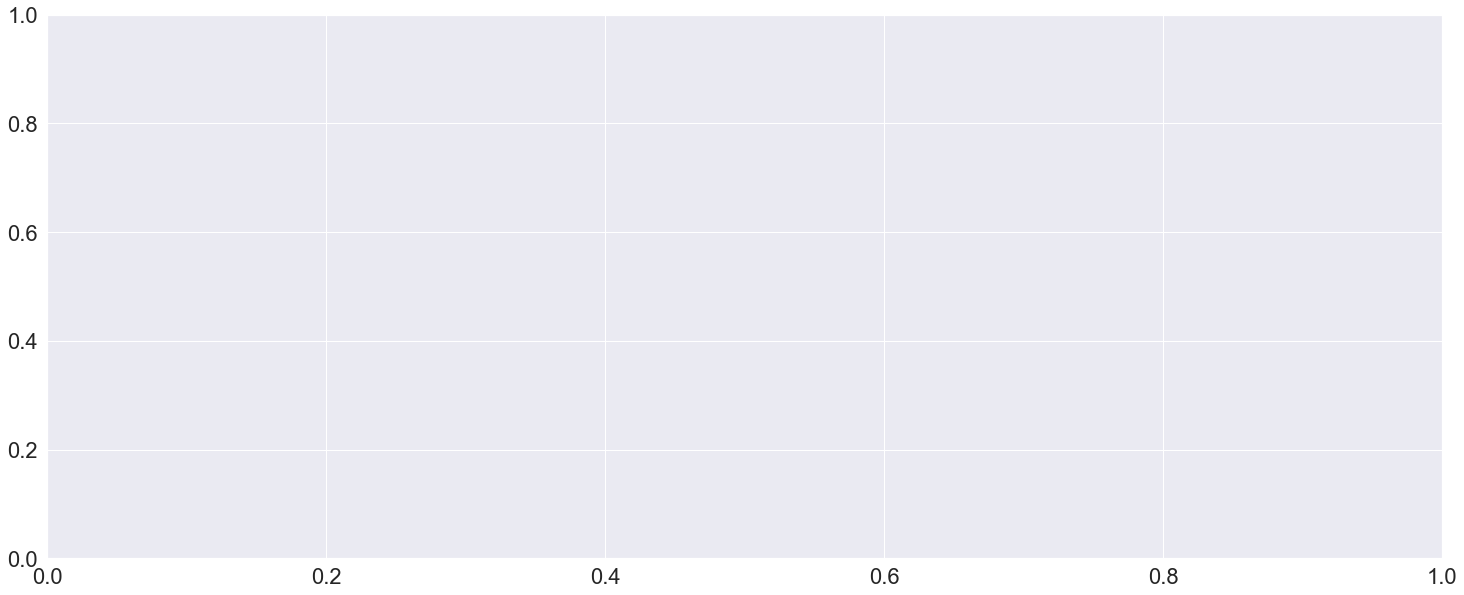

In [60]:

#############################################################################################################
# Widget interface
output_equilib = widgets.Output()
output_equilib.layout = Layout(border='solid')
output_equilib_save = widgets.Output(Layout=Layout(border='solid'))
output_legend = widgets.Output()
btn_equilib = widgets.Button(description ="View Equilibrium dynamic",button_style='info')

sldr_equilib = widgets.IntSlider(description='Starting interval',min=0,step=1,max=intervals, value=intervals)

btn_equilib_save = widgets.Button(description = "Save Graph as png",button_style='info')

drp_equilib = widgets.Dropdown(description ="Compartment")

hbox_equilib = widgets.HBox(children=[drp_equilib,sldr_equilib])
options_arr = []


for i in range(len(comp_names_arr)):
    options_arr.append(comp_names_arr[i]) 
    
drp_equilib.options = options_arr


display(hbox_equilib, btn_equilib, output_equilib, output_equilib_save)

#############################################################################################################
# Creating Equilibria figures



def btn_equilib_clicked(b):
    
    #### Instantiating figure
    
    
    
    int_equilib = sldr_equilib.value-1
  
    #ISOLATING SPECIFIC COMPARTMENT
    temp_name = drp_equilib.value 
    temp_num = 0 
    
    for i in range(len(comp_names_arr)):
        if comp_names_arr[i] == temp_name:
            temp_num = i
            
    shapes_arr =[]
    display(btn_equilib_save)
    
    with output_equilib:
        
        output_equilib.clear_output()
        
        
        f1 = mplt.figure(figsize=(25,10))
        ax = mplt.gca()
        
        ######### Main compartment:
        
        mainx = 32 #starting x-coordinate for main rectangle if not the last compartment
        mainy = 4  #starting y-coordinate for main rectangle
        main_rect = mpatches.Rectangle([mainx,mainy],20,16, fc='#c4c4ff',ec='red')
        main_atpase = mpatches.Ellipse([mainx+3,mainy+16],width=2, height=4,fc = '#964b00')
        main_kcc2 = mpatches.Ellipse([mainx+8,mainy+16],width=4, height=2,fc = '#8f4f66')
        shapes_arr.append(main_rect)
        shapes_arr.append(main_atpase)
        shapes_arr.append(main_kcc2)
        
        m_net_in = 0
        m_net_out = 0

        ######## Main ATPASE:
        
        m_na_atpase = master_arr[temp_num][int_equilib][11]*1e23 * master_arr[temp_num][int_equilib][3]
        
        if m_na_atpase >0: #Sodium coming into the compartment           
            arrow_size = m_na_atpase *2
            m_na_atpase_arrow = mpatches.FancyArrow(mainx+3, mainy+16,0,-arrow_size,width=0.2,ec='#e7298a',fc='#e7298a',ls='--')
        else:
            arrow_size = -m_na_atpase *2
            m_na_atpase_arrow = mpatches.FancyArrow(mainx+3, mainy+16,0,+arrow_size,width=0.2,ec='#e7298a',fc='#e7298a',ls='--')
        shapes_arr.append(m_na_atpase_arrow)
        
        m_k_atpase = master_arr[temp_num][int_equilib][14]*1e23   * master_arr[temp_num][int_equilib][3]
        
        if m_k_atpase >0: #Potassium coming into the compartment
            arrow_size = m_k_atpase *2
            m_k_atpase_arrow = mpatches.FancyArrow(mainx+3, mainy+16,0,-arrow_size,width=0.2, ec='#7570b3',fc='#7570b3',ls='--')
        else:
            arrow_size = -m_k_atpase *2
            m_k_atpase_arrow = mpatches.FancyArrow(mainx+3, mainy+16,0,+arrow_size,width=0.2, ec='#7570b3',fc='#7570b3',ls='--')

        shapes_arr.append(m_k_atpase_arrow)
        
        ######## Main KCC2:
        
        m_k_kcc2 = master_arr[temp_num][int_equilib][15]*1e23 * master_arr[temp_num][int_equilib][3]
        if m_k_kcc2 >0: #Potassium entering via KCC2
            arrow_size = m_k_kcc2 *2
            m_k_kcc2_arrow = mpatches.FancyArrow(mainx+7, mainy+16,0,-arrow_size,width=0.2,ec='#7570b3',fc='#7570b3',ls='--')
        
        else:
            arrow_size = -m_k_kcc2 *2
            m_k_kcc2_arrow = mpatches.FancyArrow(mainx+7, mainy+16,0,+arrow_size,width=0.2,ec='#7570b3',fc='#7570b3',ls='--')
            
        shapes_arr.append(m_k_kcc2_arrow)
        
        m_cl_kcc2 = master_arr[temp_num][int_equilib][18]*1e23  *master_arr[temp_num][int_equilib][3]
        if m_cl_kcc2 >0: #cl coming into the compartment
            arrow_size = m_cl_kcc2*2
            m_cl_kcc2_arrow = mpatches.FancyArrow(mainx+9, mainy+16,0,-arrow_size,width=0.2, ec='#1b9e77',fc='#1b9e77',ls='--')
            
        else:
            arrow_size = -m_cl_kcc2*2
            m_cl_kcc2_arrow = mpatches.FancyArrow(mainx+9, mainy+16,0,+arrow_size,width=0.2, ec='#1b9e77',fc='#1b9e77',ls='--')
        shapes_arr.append(m_cl_kcc2_arrow)
        
            
        ########## Main Na Leak:
        
        m_na_leak = mpatches.Rectangle([mainx+12, mainy+15.5], 2,1,fc='#000000') 
        shapes_arr.append(m_na_leak)
        
        m_d_na = master_arr[temp_num][int_equilib][10]*1e23  * master_arr[temp_num][int_equilib][3]
        if m_d_na >0: #sodium coming into the compartment
            arrow_size = m_d_na*2
            m_na_arrow = mpatches.FancyArrow(mainx+13, mainy+16, 0, -arrow_size, width=0.2,ec='#e7298a',fc='#e7298a')
           
        else:
            arrow_size = -m_d_na*2
            m_na_arrow = mpatches.FancyArrow(mainx+13, mainy+16, 0, +arrow_size, width=0.2,ec='#e7298a',fc='#e7298a')
            
         
        shapes_arr.append(m_na_arrow)

        ########## Main K Leak:
        
        m_k_leak = mpatches.Rectangle([mainx+15, mainy+15.5], 2,1,fc='#000000')
        shapes_arr.append(m_k_leak)
        
        m_d_k = master_arr[temp_num][int_equilib][13]*1e23 * master_arr[temp_num][int_equilib][3]
        if m_d_k >0: #potassium coming into the compartment
            arrow_size = m_d_k*2
            m_k_arrow = mpatches.FancyArrow(mainx+16, mainy+16, 0, -arrow_size, width=0.2,ec='#7570b3',fc='#7570b3')
          
        else:
            arrow_size = -m_d_k*2
            m_k_arrow = mpatches.FancyArrow(mainx+16, mainy+16, 0, +arrow_size, width=0.2,ec='#7570b3',fc='#7570b3')
           
        shapes_arr.append(m_k_arrow)

        ########## Main Cl Leak:
        
        m_cl_leak = mpatches.Rectangle([mainx+18, mainy+15.5], 2,1,fc='#000000')
        shapes_arr.append(m_cl_leak)
        
        m_d_cl = master_arr[temp_num][int_equilib][17]*1e23  * master_arr[temp_num][int_equilib][3]
        if m_d_cl >0: #chloride coming into selected (main) compartment
            arrow_size = m_d_cl*2
            m_cl_arrow = mpatches.FancyArrow(mainx+19, mainy+16, 0, -arrow_size, width=0.2,ec='#1b9e77',fc='#1b9e77')
            
        else:
            arrow_size = -m_d_cl*2
            m_cl_arrow = mpatches.FancyArrow(mainx+19, mainy+16, 0, +arrow_size, width=0.2,ec='#1b9e77',fc='#1b9e77')
            
        shapes_arr.append(m_cl_arrow)




        ######## Right Compartment

        rightx = mainx+21
        righty = 4
        right_comp=False
        r_net_in =0
        r_net_out =0

        if temp_num+1 != len(comp_names_arr):   #if not the last componenent, make rectangle on right

            right_comp = True
            right_rect = mpatches.Rectangle([rightx,righty],20,16, fc='#ebebff')
            right_atpase = mpatches.Ellipse([rightx+3,righty+16],width=2, height=4,fc = '#964b00')
            right_kcc2 = mpatches.Ellipse([rightx+8,righty+16],width=4, height=2,fc = '#8f4f66')
            shapes_arr.append(right_rect)
            shapes_arr.append(right_atpase)
            shapes_arr.append(right_kcc2)
            
            
            #### Right ATPase
            r_na_atpase = master_arr[temp_num+1][int_equilib][11]*1e23* master_arr[temp_num+1][int_equilib][3]
            if r_na_atpase >0: #Sodium coming into the compartment
                arrow_size = r_na_atpase*2
                r_na_atpase_arrow = mpatches.FancyArrow(rightx+3, righty+16,0,-arrow_size,width=0.2,ec='#e7298a',fc='#e7298a',ls='--')
        
            else:
                arrow_size = -r_na_atpase *2
                r_na_atpase_arrow = mpatches.FancyArrow(rightx+3, righty+16,0,+arrow_size,width=0.2,ec='#e7298a',fc='#e7298a',ls='--')
                
                
            shapes_arr.append(r_na_atpase_arrow)

            r_k_atpase = master_arr[temp_num+1][int_equilib][14]*1e23* master_arr[temp_num+1][int_equilib][3]
            if r_k_atpase >0: #Sodium coming into the compartment
                arrow_size = r_k_atpase *2 
                r_k_atpase_arrow = mpatches.FancyArrow(rightx+3, righty+16,0,-arrow_size,width=0.2, ec='#7570b3',fc='#7570b3',ls='--')
              
            else:
                arrow_size = -r_k_atpase *2 
                r_k_atpase_arrow = mpatches.FancyArrow(rightx+3, righty+16,0,+arrow_size,width=0.2, ec='#7570b3',fc='#7570b3',ls='--')
               
            shapes_arr.append(r_k_atpase_arrow)
            
            ######## Right KCC2:
        
            r_k_kcc2 = master_arr[temp_num+1][int_equilib][15]*1e23* master_arr[temp_num+1][int_equilib][3]
            if r_k_kcc2 >0: #Potassium entering via KCC2
                arrow_size = r_k_kcc2*2
                r_k_kcc2_arrow = mpatches.FancyArrow(rightx+7, righty+16,0,-arrow_size,width=0.2,ec='#7570b3',fc='#7570b3',ls='--')
               
            else:
                arrow_size = -r_k_kcc2 *2 
                r_k_kcc2_arrow = mpatches.FancyArrow(rightx+7, righty+16,0,+arrow_size,width=0.2,ec='#7570b3',fc='#7570b3',ls='--')
                
                
            shapes_arr.append(r_k_kcc2_arrow)

            r_cl_kcc2 =  master_arr[temp_num+1][int_equilib][18]*1e23 * master_arr[temp_num+1][int_equilib][3]
            if r_cl_kcc2 >0: #Cl coming into the compartment via KCC2
                arrow_size = +r_cl_kcc2*2  
                r_cl_kcc2_arrow = mpatches.FancyArrow(rightx+9, righty+16,0,-arrow_size,width=0.2, ec='#1b9e77',fc='#1b9e77',ls='--')
               
            else:
                arrow_size = -r_cl_kcc2 *2    
                r_cl_kcc2_arrow = mpatches.FancyArrow(rightx+9, righty+16,0,+arrow_size,width=0.2, ec='#1b9e77',fc='#1b9e77',ls='--')
                
            shapes_arr.append(r_cl_kcc2_arrow)
        
            
            #d_Na
            
            r_na_leak = mpatches.Rectangle([rightx+12, righty+15.5], 2,1,fc='#000000')
            shapes_arr.append(r_na_leak)
            
            r_d_na = master_arr[temp_num+1][int_equilib][10]*1e23 * master_arr[temp_num+1][int_equilib][3]
            if r_d_na >0: #sodium coming into the compartment
                arrow_size = r_d_na *2
                r_na_arrow = mpatches.FancyArrow(rightx+13, righty+16, 0, -arrow_size, width=0.2,ec='#e7298a',fc='#e7298a')
               
            else:
                arrow_size = -r_d_na*2 
                r_na_arrow = mpatches.FancyArrow(rightx+13, righty+16, 0, +arrow_size, width=0.2,ec='#e7298a',fc='#e7298a')
             
            shapes_arr.append(r_na_arrow)

            #d_K
            
            r_k_leak = mpatches.Rectangle([rightx+15, righty+15.5], 2,1,fc='#000000')
            shapes_arr.append(r_k_leak)
            
            r_d_k = master_arr[temp_num+1][int_equilib][13]*1e23* master_arr[temp_num+1][int_equilib][3]
            if r_d_k >0: #potassium coming into the compartment
                arrow_size = r_d_k*2
                r_k_arrow = mpatches.FancyArrow(rightx+16, righty+16, 0, -arrow_size, width=0.2,ec='#7570b3',fc='#7570b3')
     
            else:
                arrow_size = -r_d_k *2
                r_k_arrow = mpatches.FancyArrow(rightx+16, righty+16, 0, +arrow_size, width=0.2,ec='#7570b3',fc='#7570b3')
                
            shapes_arr.append(r_k_arrow)


            #d_Cl
            
            r_cl_leak = mpatches.Rectangle([rightx+18, righty+15.5], 2,1,fc='#000000')
            shapes_arr.append(r_cl_leak)
            
            r_d_cl = master_arr[temp_num+1][int_equilib][17]*1e23 * master_arr[temp_num+1][int_equilib][3]
            if r_d_cl >0: #chloride coming into the compartment
                arrow_size = r_d_cl*2
                r_cl_arrow = mpatches.FancyArrow(rightx+19, righty+16, 0, -arrow_size, width=0.2,ec='#1b9e77',fc='#1b9e77')
              
            else:
                arrow_size = -r_d_cl*2
                r_cl_arrow = mpatches.FancyArrow(rightx+19, righty+16, 0, +arrow_size, width=0.2,ec='#1b9e77',fc='#1b9e77')
              
            shapes_arr.append(r_cl_arrow)

            #Right Electrodiffusion
            """
            r_ed_arr = ED_master_arr[temp_num][-1]
            
            r_ed_na = r_ed_arr[0]*1e15
            arrow_size = r_ed_na
            if r_ed_na >0: 
                r_ed_na_arrow = mpatches.FancyArrow(rightx, righty+8, arrow_size, 0, width=0.2,ec='#e7298a',fc='#e7298a',ls='dotted')

            else:
                r_ed_na_arrow = mpatches.FancyArrow(rightx, righty+8, -arrow_size, 0, width=0.2,ec='#e7298a',fc='#e7298a',ls ='dotted')
              
            shapes_arr.append(r_ed_na_arrow)
               

            r_ed_k = r_ed_arr[1]*1e15
            arrow_size= r_ed_k
            if r_ed_k >0:
                r_ed_k_arrow = mpatches.FancyArrow(rightx, righty+6, arrow_size, 0, width=0.2,ec='#7570b3',fc='#7570b3')
    
            else:
                r_ed_k_arrow = mpatches.FancyArrow(rightx, righty+6, -arrow_size, 0, width=0.2,ec='#7570b3',fc='#7570b3')
               
            shapes_arr.append(r_ed_k_arrow)
                

            r_ed_cl = r_ed_arr[2]*1e15
            arrow_size = r_ed_cl
            if r_ed_cl >0: 
                r_ed_cl_arrow = mpatches.FancyArrow(rightx, righty+4, +arrow_size, 0, width=0.2,ec='#1b9e77',fc='#1b9e77')
                    
                
            else:
                r_ed_cl_arrow = mpatches.FancyArrow(rightx, righty+4, -arrow_size, 0, width=0.2,ec='#1b9e77',fc='#1b9e77')
                
            shapes_arr.append(r_ed_cl_arrow)
               
            """  

        ######## Left Compartment

        leftx = mainx-21
        lefty=4
        left_comp=False
        l_net_in =0
        l_net_out =0

        if temp_num+1 != 1:   #if not the first componenent, make rectangle on left

            left_comp = True
            left_rect = mpatches.Rectangle([leftx,lefty],20,16, fc='#ebebff')
            shapes_arr.append(left_rect)
            left_atpase = mpatches.Ellipse([leftx+3,lefty+16],width=2, height=4,fc = '#964b00')
            left_kcc2 = mpatches.Ellipse([leftx+8,lefty+16],width=4, height=2,fc = '#8f4f66')
            shapes_arr.append(left_atpase)
            shapes_arr.append(left_kcc2)
            
            #### Left ATPase
            l_na_atpase = master_arr[temp_num-1][int_equilib][11]*1e23* master_arr[temp_num-1][int_equilib][3]
            if l_na_atpase >0: #Sodium coming into the compartment
                arrow_size = l_na_atpase*2 
                l_na_atpase_arrow = mpatches.FancyArrow(leftx+3, lefty+16,0,-arrow_size,width=0.2,ec='#e7298a',fc='#e7298a',ls='--')

            else:
                arrow_size = -l_na_atpase *2
                l_na_atpase_arrow = mpatches.FancyArrow(leftx+3, lefty+16,0,+arrow_size,width=0.2,ec='#e7298a',fc='#e7298a',ls='--')
                
              
            shapes_arr.append(l_na_atpase_arrow)

            l_k_atpase = master_arr[temp_num-1][int_equilib][14]*1e23* master_arr[temp_num-1][int_equilib][3]
            if l_k_atpase >0: #Sodium coming into the compartment
                arrow_size = l_k_atpase*2 
                l_k_atpase_arrow = mpatches.FancyArrow(leftx+3, lefty+16,0,-arrow_size,width=0.2, ec='#7570b3',fc='#7570b3',ls='--')

            else:
                arrow_size = -l_k_atpase*2 
                l_k_atpase_arrow = mpatches.FancyArrow(leftx+3, lefty+16,0,+arrow_size,width=0.2, ec='#7570b3',fc='#7570b3',ls='--')
                
                
            shapes_arr.append(l_k_atpase_arrow)
            
            ######## Left KCC2:
        
            l_k_kcc2 = master_arr[temp_num-1][int_equilib][15]*1e23* master_arr[temp_num-1][int_equilib][3]
            if l_k_kcc2 >0: #Potassium entering via KCC2
                arrow_size = l_k_kcc2*2
                l_k_kcc2_arrow = mpatches.FancyArrow(leftx+7, lefty+16,0,-arrow_size,width=0.2,ec='#7570b3',fc='#7570b3',ls='--')
           
            else:
                arrow_size = -l_k_kcc2*2
                l_k_kcc2_arrow = mpatches.FancyArrow(leftx+7, lefty+16,0,+arrow_size,width=0.2,ec='#7570b3',fc='#7570b3',ls='--')
                 
            shapes_arr.append(l_k_kcc2_arrow)

            l_cl_kcc2 = master_arr[temp_num-1][int_equilib][18]*1e23* master_arr[temp_num-1][int_equilib][3]
            if l_cl_kcc2 >0: #Sodium coming into the compartment
                arrow_size = l_cl_kcc2*2
                l_cl_kcc2_arrow = mpatches.FancyArrow(leftx+9, lefty+16,0,-arrow_size,width=0.2, ec='#1b9e77',fc='#1b9e77',ls='--')
             
            else:
                arrow_size = -l_cl_kcc2*2
                l_cl_kcc2_arrow = mpatches.FancyArrow(leftx+9, lefty+16,0,+arrow_size,width=0.2, ec='#1b9e77',fc='#1b9e77',ls='--')
                
            shapes_arr.append(l_cl_kcc2_arrow)
            
            #d_Na
            
            l_na_leak = mpatches.Rectangle([leftx+12, lefty+15.5], 2,1,fc='#000000')
            shapes_arr.append(l_na_leak)
            
            l_d_na = master_arr[temp_num-1][int_equilib][10]*1e23* master_arr[temp_num-1][int_equilib][3]
            if l_d_na >0: #sodium coming into the left compartment
                arrow_size = l_d_na*2
                l_na_arrow = mpatches.FancyArrow(leftx+13, lefty+16, 0, -arrow_size, width=0.2, ec='#e7298a',fc='#e7298a')
                
             
            else:
                arrow_size = -l_d_na*2
                l_na_arrow = mpatches.FancyArrow(leftx+13, lefty+16, 0, +arrow_size, width=0.2,ec='#e7298a',fc='#e7298a')
                
            shapes_arr.append(l_na_arrow)

            #d_K
            
            l_k_leak = mpatches.Rectangle([leftx+15, lefty+15.5], 2,1,fc='#000000')
            shapes_arr.append(l_k_leak)
            
            l_d_k = master_arr[temp_num-1][int_equilib][13]*1e23 * master_arr[temp_num-1][int_equilib][3]
            if l_d_k >0: #potassium coming into the compartment
                arrow_size = l_d_k*2
                l_k_arrow = mpatches.FancyArrow(leftx+16, lefty+16, 0, -arrow_size, width=0.2,ec='#7570b3',fc='#7570b3')
                
            else:
                arrow_size = -l_d_k*2
                l_k_arrow = mpatches.FancyArrow(leftx+16, lefty+16, 0, +arrow_size, width=0.2,ec='#7570b3',fc='#7570b3')
               
            shapes_arr.append(l_k_arrow)


            #d_Cl
            
            l_cl_leak = mpatches.Rectangle([leftx+18, lefty+15.5], 2,1,fc='#000000')
            shapes_arr.append(l_cl_leak)
            
            l_d_cl = master_arr[temp_num-1][int_equilib][17]*1e23* master_arr[temp_num-1][int_equilib][3]
            if l_d_cl >0: #chloride coming into the compartment
                arrow_size = l_d_cl*2
                l_cl_arrow = mpatches.FancyArrow(leftx+19, lefty+16, 0, -arrow_size, width=0.2,ec='#1b9e77',fc='#1b9e77')
                
            else:
                arrow_size = -l_d_cl*2
                l_cl_arrow = mpatches.FancyArrow(leftx+19, lefty+16, 0, +arrow_size, width=0.2,ec='#1b9e77',fc='#1b9e77')
            
            shapes_arr.append(l_cl_arrow)


            #Left compartment boundary (electrodiffusion):
            """"
            l_ed_arr = ED_master_arr[temp_num-1][-1]

            l_ed_na = l_ed_arr[0]*1e10
            if l_ed_na >0: #sodium leaving the L compartment, entering main compartment via ED
                l_ed_na_arrow = mpatches.FancyArrow(mainx-4, mainy+8, +5, 0, width=0.2,ec='#e7298a',fc='#e7298a',hatch ='+')
               
                shapes_arr.append(l_ed_na_arrow)
              
                
            else: # sodium entering via ED
                l_ed_na_arrow = mpatches.FancyArrow(mainx+2, mainy+8, -5, 0, width=0.2,ec='#e7298a',fc='#e7298a',ls =':')
                
                shapes_arr.append(l_ed_na_arrow)
               

            l_ed_k = l_ed_arr[1]*1e10
            if l_ed_k >0: #K leaving the compartment via ED
                l_ed_k_arrow = mpatches.FancyArrow(mainx-4, mainy+6, +5, 0, width=0.2,ec='#7570b3',fc='#7570b3')
                
                shapes_arr.append(l_ed_k_arrow)
               
            else:
                l_ed_k_arrow = mpatches.FancyArrow(mainx+2, mainy+6, -5, 0, width=0.2,ec='#7570b3',fc='#7570b3')
                
                shapes_arr.append(l_ed_k_arrow)
               

            l_ed_cl = l_ed_arr[2]*1e10
            if l_ed_cl >0: #sodium coming into the compartment
                l_ed_cl_arrow = mpatches.FancyArrow(mainx-4, mainy+4, +5, 0, width=0.2,ec='#1b9e77',fc='#1b9e77')
              
                shapes_arr.append(l_ed_cl_arrow)
              
            else:
                l_ed_cl_arrow = mpatches.FancyArrow(mainx+2, mainy+4, -5, 0, width=0.2,ec='#1b9e77',fc='#1b9e77')
                
                shapes_arr.append(l_ed_cl_arrow)
                
            """


        ######### legend
        leg_rect = mpatches.Rectangle([65,32],8,12, fc='white', ec='black')
        shapes_arr.append(leg_rect)
        ax.text(65.5,44.2,"Legend", fontsize=13)
        
        leg_na_arrow = mpatches.FancyArrow(69, 42.5, 2, 0, width=0.1,ec='#e7298a',fc='#e7298a')
        shapes_arr.append(leg_na_arrow)
        ax.text(65.5,42.5,"Na+", fontsize=12)
        
        leg_k_arrow = mpatches.FancyArrow(69, 41, 2, 0, width=0.1,ec='#7570b3',fc='#7570b3')
        shapes_arr.append(leg_k_arrow)
        ax.text(65.5,41,"K+", fontsize=12)
        
        leg_cl_arrow = mpatches.FancyArrow(69, 39.5, 2, 0, width=0.1,ec='#1b9e77',fc='#1b9e77')
        shapes_arr.append(leg_cl_arrow)
        ax.text(65.5,39.5,"Cl-", fontsize=12)
        
        leg_atpase = mpatches.Ellipse([71,37],width=1, height=2,fc = '#964b00')
        shapes_arr.append(leg_atpase)
        ax.text(65.5,37,"ATPase", fontsize=12)
        
        leg_kcc2 = mpatches.Ellipse([71,35],width=2, height=1,fc = '#8f4f66')
        shapes_arr.append(leg_kcc2)
        ax.text(65.5,35,"KCC2", fontsize=12)
        
        leg_leak = mpatches.Rectangle([70, 33], 2,1,fc='#000000')
        shapes_arr.append(leg_leak)
        ax.text(65.5,33,"Leak", fontsize=12)




        for j in range(len(shapes_arr)):
            ax.add_patch(shapes_arr[j])

        

        ax.text(mainx+8.5,mainy+1,temp_name, fontsize=16)

        if left_comp == True: 
            ax.text(leftx+8.5,lefty+1,comp_names_arr[temp_num-1], fontsize=16)

        if right_comp == True: 
            ax.text(rightx+8.5,righty+1,comp_names_arr[temp_num+1], fontsize=16)

        mplt.axis("Scaled")
        #ax.text(mainx,30,"**All values are in 10^6 mM", fontsize=16)
        ax.axis("off")
        
        mplt.show()
        
        def btn_equilib_save_clicked(b):
    
            f1.savefig("BOUNDARY",format='png')
            print("Figure titled BOUNDARY saved in local directory")
                       
        btn_equilib_save.on_click(btn_equilib_save_clicked)

        
        
    
        
###########################################################################################################        
        

        
        

#############################################################################################################    
# Connecting button to backend

btn_equilib.on_click(btn_equilib_clicked)

## C2) Arrows only boundary

In [61]:

#############################################################################################################
# Widget interface
output_equilib2 = widgets.Output()
output_equilib2.layout = Layout(border='solid')
output_equilib2_save = widgets.Output(Layout=Layout(border='solid'))
output_legend2 = widgets.Output()
btn_equilib = widgets.Button(description ="View Equilibrium dynamic",button_style='info')

sldr_equilib = widgets.IntSlider(description='Starting interval',min=0,step=1,max=intervals, value=intervals)

btn_equilib_save = widgets.Button(description = "Save Graph as png",button_style='info')

drp_equilib = widgets.Dropdown(description ="Compartment")

hbox_equilib = widgets.HBox(children=[drp_equilib,sldr_equilib])
options_arr = []


for i in range(len(comp_names_arr)):
    options_arr.append(comp_names_arr[i]) 
    
drp_equilib.options = options_arr


display(hbox_equilib, btn_equilib, output_equilib2, output_equilib2_save)
display(btn_equilib_save)
#############################################################################################################
# Creating Equilibria figures



def btn_equilib_clicked(b):
    
    #### Instantiating figure
    
    
    
    int_equilib = sldr_equilib.value-1
  
    #ISOLATING SPECIFIC COMPARTMENT
    temp_name = drp_equilib.value 
    temp_num = 0 
    
    for i in range(len(comp_names_arr)):
        if comp_names_arr[i] == temp_name:
            temp_num = i
            
    shapes_arr =[]
 
    
    with output_equilib2:
        
        output_equilib2.clear_output()
        
        
        f1 = mplt.figure(figsize=(25,10))
        ax = mplt.gca()
        
        ######### Main compartment:
        
        mainx = 32 #starting x-coordinate for main rectangle if not the last compartment
        mainy = 4  #starting y-coordinate for main rectangle
        main_rect = mpatches.Rectangle([mainx,mainy],20,16, fc='#c4c4ff',ec='red')

        shapes_arr.append(main_rect)       
        
        ######## Main Transmembrane
        
       
        m_na_memb = df_end_flux.iloc[temp_num][0]*1e27
        m_na_memb_arrow = mpatches.FancyArrow(mainx+8, mainy+16,0,-m_na_memb,width=0.4,ec='#e7298a',fc='#e7298a',ls='--')
        shapes_arr.append(m_na_memb_arrow)
        m_k_memb = df_end_flux.iloc[temp_num][3]*1e27   
        m_k_memb_arrow = mpatches.FancyArrow(mainx+11, mainy+16,0,-m_k_memb,width=0.4, ec='#7570b3',fc='#7570b3',ls='--')
        shapes_arr.append(m_k_memb_arrow)
        m_cl_memb = df_end_flux.iloc[temp_num][7]*1e27   
        m_cl_memb_arrow = mpatches.FancyArrow(mainx+14, mainy+16,0,-m_cl_memb,width=0.4, ec='#1b9e77',fc='#1b9e77',ls='--')
        shapes_arr.append(m_cl_memb_arrow)
        
        

        ######## Right Compartment

        rightx = mainx+20
        righty = 4
        right_comp=False
        r_net_in =0
        r_net_out =0

        if temp_num+1 != len(comp_names_arr):   #if not the last componenent, make rectangle on right

            right_comp = True
            right_rect = mpatches.Rectangle([rightx,righty],20,16, fc='#ebebff')
            shapes_arr.append(right_rect)
        
            r_na_memb = df_end_flux.iloc[temp_num+1][0]*1e27
            r_na_memb_arrow = mpatches.FancyArrow(rightx+8, righty+16,0,-r_na_memb,width=0.4,ec='#e7298a',fc='#e7298a',ls='--')
            shapes_arr.append(r_na_memb_arrow)
            r_k_memb = df_end_flux.iloc[temp_num+1][3]*1e27   
            r_k_memb_arrow = mpatches.FancyArrow(rightx+11, righty+16,0,-r_k_memb,width=0.4, ec='#7570b3',fc='#7570b3',ls='--')
            shapes_arr.append(r_k_memb_arrow)
            r_cl_memb = df_end_flux.iloc[temp_num+1][7]*1e27   
            r_cl_memb_arrow = mpatches.FancyArrow(rightx+14, righty+16,0,-r_cl_memb,width=0.4, ec='#1b9e77',fc='#1b9e77',ls='--')
            shapes_arr.append(r_cl_memb_arrow)

            #Right Electrodiffusion
           
            
            r_ed_na = df_end_ed.iloc[temp_num][0]*1e45
            r_ed_na_arrow = mpatches.FancyArrow(rightx, righty+8, r_ed_na, 0, width=0.2,ec='#e7298a',fc='#e7298a',ls ='dotted')
            shapes_arr.append(r_ed_na_arrow)
            r_ed_k = df_end_ed.iloc[temp_num][1]*1e45
            r_ed_k_arrow = mpatches.FancyArrow(rightx, righty+6, r_ed_k, 0, width=0.2,ec='#7570b3',fc='#7570b3')
            shapes_arr.append(r_ed_k_arrow)
            r_ed_cl = df_end_ed.iloc[temp_num][2]*1e45
            r_ed_cl_arrow = mpatches.FancyArrow(rightx, righty+4,r_ed_cl, 0, width=0.2,ec='#1b9e77',fc='#1b9e77')
            shapes_arr.append(r_ed_cl_arrow)
               
            

        ######## Left Compartment

        leftx = mainx-20
        lefty=4
        left_comp=False
        l_net_in =0
        l_net_out =0

        if temp_num+1 != 1:   #if not the first componenent, make rectangle on left

            left_comp = True
            left_rect = mpatches.Rectangle([leftx,lefty],20,16, fc='#ebebff')
            shapes_arr.append(left_rect)
            
            
            l_na_memb = df_end_flux.iloc[temp_num-1][0]*1e27
            l_na_memb_arrow = mpatches.FancyArrow(leftx+8, lefty+16,0,-l_na_memb,width=0.4,ec='#e7298a',fc='#e7298a',ls='--')
            shapes_arr.append(l_na_memb_arrow)
            l_k_memb = df_end_flux.iloc[temp_num-1][3]*1e27   
            l_k_memb_arrow = mpatches.FancyArrow(leftx+11, lefty+16,0,-l_k_memb,width=0.4, ec='#7570b3',fc='#7570b3',ls='--')
            shapes_arr.append(l_k_memb_arrow)
            l_cl_memb = df_end_flux.iloc[temp_num-1][7]*1e27   
            l_cl_memb_arrow = mpatches.FancyArrow(leftx+14, lefty+16,0,-l_cl_memb,width=0.4, ec='#1b9e77',fc='#1b9e77',ls='--')
            shapes_arr.append(l_cl_memb_arrow)

            #Left compartment boundary (electrodiffusion):
            l_ed_na = df_end_ed.iloc[temp_num-1][0]*1e45
            l_ed_na_arrow = mpatches.FancyArrow(mainx, lefty+8, l_ed_na, 0, width=0.2,ec='#e7298a',fc='#e7298a',ls ='dotted')
            shapes_arr.append(l_ed_na_arrow)
            l_ed_k = df_end_ed.iloc[temp_num-1][1]*1e45
            l_ed_k_arrow = mpatches.FancyArrow(mainx, lefty+6, l_ed_k, 0, width=0.2,ec='#7570b3',fc='#7570b3')
            shapes_arr.append(l_ed_k_arrow)
            l_ed_cl = df_end_ed.iloc[temp_num-1][2]*1e45
            l_ed_cl_arrow = mpatches.FancyArrow(mainx, lefty+4,l_ed_cl, 0, width=0.2,ec='#1b9e77',fc='#1b9e77')
            shapes_arr.append(l_ed_cl_arrow)


        ######### legend
        leg_rect = mpatches.Rectangle([65,38],8,6, fc='white', ec='black')
        shapes_arr.append(leg_rect)
        ax.text(65.5,44.2,"Legend", fontsize=13)
        
        leg_na_arrow = mpatches.FancyArrow(69, 42.5, 2, 0, width=0.1,ec='#e7298a',fc='#e7298a')
        shapes_arr.append(leg_na_arrow)
        ax.text(65.5,42.5,"Na+", fontsize=12)
        
        leg_k_arrow = mpatches.FancyArrow(69, 41, 2, 0, width=0.1,ec='#7570b3',fc='#7570b3')
        shapes_arr.append(leg_k_arrow)
        ax.text(65.5,41,"K+", fontsize=12)
        
        leg_cl_arrow = mpatches.FancyArrow(69, 39.5, 2, 0, width=0.1,ec='#1b9e77',fc='#1b9e77')
        shapes_arr.append(leg_cl_arrow)
        ax.text(65.5,39.5,"Cl-", fontsize=12)



        for j in range(len(shapes_arr)):
            ax.add_patch(shapes_arr[j])

        

        ax.text(mainx+8.5,mainy+1,temp_name, fontsize=16)

        if left_comp == True: 
            ax.text(leftx+8.5,lefty+1,comp_names_arr[temp_num-1], fontsize=16)

        if right_comp == True: 
            ax.text(rightx+8.5,righty+1,comp_names_arr[temp_num+1], fontsize=16)

        mplt.axis("Scaled")
        #ax.text(mainx,30,"**All values are in 10^6 mM", fontsize=16)
        ax.axis("off")
        
        mplt.show()
        
        def btn_equilib_save_clicked(b):
    
            f1.savefig("BOUNDARY",format='png')
            print("Figure titled BOUNDARY saved in local directory")
                       
        btn_equilib_save.on_click(btn_equilib_save_clicked)


#############################################################################################################    
# Connecting button to backend

btn_equilib.on_click(btn_equilib_clicked)

Button(button_style='info', description='View Equilibrium dynamic', style=ButtonStyle())

Output(layout=Layout(border='solid'))

Output()

Button(button_style='info', description='Save Graph as png', style=ButtonStyle())

## C3) Relative compartments boundary

Arrow lengths in adjacent compartments are relative to the arrow length in the selected compartment, can't compare arrows with each other, only with the same channel in the adjacent compartment.

In [62]:

#############################################################################################################
# Widget interface
output_equilib3 = widgets.Output()
output_equilib3.layout = Layout(border='solid')
output_equilib3_save = widgets.Output(Layout=Layout(border='solid'))
output_legend3 = widgets.Output()
btn_equilib = widgets.Button(description ="View Equilibrium dynamic",button_style='info')

sldr_equilib = widgets.IntSlider(description='Starting interval',min=0,step=1,max=intervals, value=intervals)

btn_equilib_save = widgets.Button(description = "Save Graph as png",button_style='info')

drp_equilib = widgets.Dropdown(description ="Compartment")

hbox_equilib = widgets.HBox(children=[drp_equilib,sldr_equilib])
options_arr = []


for i in range(len(comp_names_arr)):
    options_arr.append(comp_names_arr[i]) 
    
drp_equilib.options = options_arr


display(hbox_equilib, btn_equilib, output_equilib3, output_equilib3_save)

#############################################################################################################
# Creating Equilibria figures



def btn_equilib_clicked(b):
    
    #### Instantiating figure
    
    
    
    int_equilib = sldr_equilib.value-1
  
    #ISOLATING SPECIFIC COMPARTMENT
    temp_name = drp_equilib.value 
    temp_num = 0 
    
    for i in range(len(comp_names_arr)):
        if comp_names_arr[i] == temp_name:
            temp_num = i
            
    shapes_arr =[]
    display(btn_equilib_save)
    
    with output_equilib3:
        
        output_equilib3.clear_output()
        
        
        f1 = mplt.figure(figsize=(25,10))
        ax = mplt.gca()
        
        ######### Main compartment:
        
        mainx = 32 #starting x-coordinate for main rectangle if not the last compartment
        mainy = 4  #starting y-coordinate for main rectangle
        main_rect = mpatches.Rectangle([mainx,mainy],20,16, fc='#c4c4ff',ec='red')
        main_atpase = mpatches.Ellipse([mainx+3,mainy+16],width=2, height=4,fc = '#964b00')
        main_kcc2 = mpatches.Ellipse([mainx+8,mainy+16],width=4, height=2,fc = '#8f4f66')
        shapes_arr.append(main_rect)
        shapes_arr.append(main_atpase)
        shapes_arr.append(main_kcc2)
        
        m_net_in = 0
        m_net_out = 0

        ######## Main ATPASE:
        
        m_na_atpase = master_arr[temp_num][int_equilib][11]*1e23 * master_arr[temp_num][int_equilib][3]
        
        if m_na_atpase >0: #Sodium coming into the compartment           
            arrow_size = m_na_atpase *2
            m_na_atpase_arrow = mpatches.FancyArrow(mainx+3, mainy+16,0,-arrow_size,width=0.2,ec='#e7298a',fc='#e7298a',ls='--')
        else:
            arrow_size = -m_na_atpase *2
            m_na_atpase_arrow = mpatches.FancyArrow(mainx+3, mainy+16,0,+arrow_size,width=0.2,ec='#e7298a',fc='#e7298a',ls='--')
        shapes_arr.append(m_na_atpase_arrow)
        
        m_k_atpase = master_arr[temp_num][int_equilib][14]*1e23   * master_arr[temp_num][int_equilib][3]
        
        if m_k_atpase >0: #Potassium coming into the compartment
            arrow_size = m_k_atpase *2
            m_k_atpase_arrow = mpatches.FancyArrow(mainx+3, mainy+16,0,-arrow_size,width=0.2, ec='#7570b3',fc='#7570b3',ls='--')
        else:
            arrow_size = -m_k_atpase *2
            m_k_atpase_arrow = mpatches.FancyArrow(mainx+3, mainy+16,0,+arrow_size,width=0.2, ec='#7570b3',fc='#7570b3',ls='--')

        shapes_arr.append(m_k_atpase_arrow)
        
        ######## Main KCC2:
        
        m_k_kcc2 = master_arr[temp_num][int_equilib][15]*1e23 * master_arr[temp_num][int_equilib][3]
        if m_k_kcc2 >0: #Potassium entering via KCC2
            arrow_size = m_k_kcc2 *2
            m_k_kcc2_arrow = mpatches.FancyArrow(mainx+7, mainy+16,0,-arrow_size,width=0.2,ec='#7570b3',fc='#7570b3',ls='--')
        
        else:
            arrow_size = -m_k_kcc2 *2
            m_k_kcc2_arrow = mpatches.FancyArrow(mainx+7, mainy+16,0,+arrow_size,width=0.2,ec='#7570b3',fc='#7570b3',ls='--')
            
        shapes_arr.append(m_k_kcc2_arrow)
        
        m_cl_kcc2 = master_arr[temp_num][int_equilib][18]*1e23  *master_arr[temp_num][int_equilib][3]
        if m_cl_kcc2 >0: #cl coming into the compartment
            arrow_size = m_cl_kcc2*2
            m_cl_kcc2_arrow = mpatches.FancyArrow(mainx+9, mainy+16,0,-arrow_size,width=0.2, ec='#1b9e77',fc='#1b9e77',ls='--')
            
        else:
            arrow_size = -m_cl_kcc2*2
            m_cl_kcc2_arrow = mpatches.FancyArrow(mainx+9, mainy+16,0,+arrow_size,width=0.2, ec='#1b9e77',fc='#1b9e77',ls='--')
        shapes_arr.append(m_cl_kcc2_arrow)
        
            
        ########## Main Na Leak:
        
        m_na_leak = mpatches.Rectangle([mainx+12, mainy+15.5], 2,1,fc='#000000') 
        shapes_arr.append(m_na_leak)
        
        m_d_na = master_arr[temp_num][int_equilib][10]*1e23  * master_arr[temp_num][int_equilib][3]
        if m_d_na >0: #sodium coming into the compartment
            arrow_size = m_d_na*2
            m_na_arrow = mpatches.FancyArrow(mainx+13, mainy+16, 0, -arrow_size, width=0.2,ec='#e7298a',fc='#e7298a')
           
        else:
            arrow_size = -m_d_na*2
            m_na_arrow = mpatches.FancyArrow(mainx+13, mainy+16, 0, +arrow_size, width=0.2,ec='#e7298a',fc='#e7298a')
            
         
        shapes_arr.append(m_na_arrow)

        ########## Main K Leak:
        
        m_k_leak = mpatches.Rectangle([mainx+15, mainy+15.5], 2,1,fc='#000000')
        shapes_arr.append(m_k_leak)
        
        m_d_k = master_arr[temp_num][int_equilib][13]*1e23 * master_arr[temp_num][int_equilib][3]
        if m_d_k >0: #potassium coming into the compartment
            arrow_size = m_d_k*2
            m_k_arrow = mpatches.FancyArrow(mainx+16, mainy+16, 0, -arrow_size, width=0.2,ec='#7570b3',fc='#7570b3')
          
        else:
            arrow_size = -m_d_k*2
            m_k_arrow = mpatches.FancyArrow(mainx+16, mainy+16, 0, +arrow_size, width=0.2,ec='#7570b3',fc='#7570b3')
           
        shapes_arr.append(m_k_arrow)

        ########## Main Cl Leak:
        
        m_cl_leak = mpatches.Rectangle([mainx+18, mainy+15.5], 2,1,fc='#000000')
        shapes_arr.append(m_cl_leak)
        
        m_d_cl = master_arr[temp_num][int_equilib][17]*1e23  * master_arr[temp_num][int_equilib][3]
        if m_d_cl >0: #chloride coming into selected (main) compartment
            arrow_size = m_d_cl*2
            m_cl_arrow = mpatches.FancyArrow(mainx+19, mainy+16, 0, -arrow_size, width=0.2,ec='#1b9e77',fc='#1b9e77')
            
        else:
            arrow_size = -m_d_cl*2
            m_cl_arrow = mpatches.FancyArrow(mainx+19, mainy+16, 0, +arrow_size, width=0.2,ec='#1b9e77',fc='#1b9e77')
            
        shapes_arr.append(m_cl_arrow)




        ######## Right Compartment

        rightx = mainx+21
        righty = 4
        right_comp=False
        r_net_in =0
        r_net_out =0

        if temp_num+1 != len(comp_names_arr):   #if not the last componenent, make rectangle on right

            right_comp = True
            right_rect = mpatches.Rectangle([rightx,righty],20,16, fc='#ebebff')
            right_atpase = mpatches.Ellipse([rightx+3,righty+16],width=2, height=4,fc = '#964b00')
            right_kcc2 = mpatches.Ellipse([rightx+8,righty+16],width=4, height=2,fc = '#8f4f66')
            shapes_arr.append(right_rect)
            shapes_arr.append(right_atpase)
            shapes_arr.append(right_kcc2)
            
            
            #### Right ATPase
            r_na_atpase = master_arr[temp_num+1][int_equilib][11]*1e23* master_arr[temp_num+1][int_equilib][3]
            if r_na_atpase >0: #Sodium coming into the compartment
                arrow_size = r_na_atpase*2
                r_na_atpase_arrow = mpatches.FancyArrow(rightx+3, righty+16,0,-arrow_size,width=0.2,ec='#e7298a',fc='#e7298a',ls='--')
        
            else:
                arrow_size = -r_na_atpase *2
                r_na_atpase_arrow = mpatches.FancyArrow(rightx+3, righty+16,0,+arrow_size,width=0.2,ec='#e7298a',fc='#e7298a',ls='--')
                
                
            shapes_arr.append(r_na_atpase_arrow)

            r_k_atpase = master_arr[temp_num+1][int_equilib][14]*1e23* master_arr[temp_num+1][int_equilib][3]
            if r_k_atpase >0: #Sodium coming into the compartment
                arrow_size = r_k_atpase *2 
                r_k_atpase_arrow = mpatches.FancyArrow(rightx+3, righty+16,0,-arrow_size,width=0.2, ec='#7570b3',fc='#7570b3',ls='--')
              
            else:
                arrow_size = -r_k_atpase *2 
                r_k_atpase_arrow = mpatches.FancyArrow(rightx+3, righty+16,0,+arrow_size,width=0.2, ec='#7570b3',fc='#7570b3',ls='--')
               
            shapes_arr.append(r_k_atpase_arrow)
            
            ######## Right KCC2:
        
            r_k_kcc2 = master_arr[temp_num+1][int_equilib][15]*1e23* master_arr[temp_num+1][int_equilib][3]
            if r_k_kcc2 >0: #Potassium entering via KCC2
                arrow_size = r_k_kcc2*2
                r_k_kcc2_arrow = mpatches.FancyArrow(rightx+7, righty+16,0,-arrow_size,width=0.2,ec='#7570b3',fc='#7570b3',ls='--')
               
            else:
                arrow_size = -r_k_kcc2 *2 
                r_k_kcc2_arrow = mpatches.FancyArrow(rightx+7, righty+16,0,+arrow_size,width=0.2,ec='#7570b3',fc='#7570b3',ls='--')
                
                
            shapes_arr.append(r_k_kcc2_arrow)

            r_cl_kcc2 =  master_arr[temp_num+1][int_equilib][18]*1e23 * master_arr[temp_num+1][int_equilib][3]
            if r_cl_kcc2 >0: #Cl coming into the compartment via KCC2
                arrow_size = +r_cl_kcc2*2  
                r_cl_kcc2_arrow = mpatches.FancyArrow(rightx+9, righty+16,0,-arrow_size,width=0.2, ec='#1b9e77',fc='#1b9e77',ls='--')
               
            else:
                arrow_size = -r_cl_kcc2 *2    
                r_cl_kcc2_arrow = mpatches.FancyArrow(rightx+9, righty+16,0,+arrow_size,width=0.2, ec='#1b9e77',fc='#1b9e77',ls='--')
                
            shapes_arr.append(r_cl_kcc2_arrow)
        
            
            #d_Na
            
            r_na_leak = mpatches.Rectangle([rightx+12, righty+15.5], 2,1,fc='#000000')
            shapes_arr.append(r_na_leak)
            
            r_d_na = master_arr[temp_num+1][int_equilib][10]*1e23 * master_arr[temp_num+1][int_equilib][3]
            if r_d_na >0: #sodium coming into the compartment
                arrow_size = r_d_na *2
                r_na_arrow = mpatches.FancyArrow(rightx+13, righty+16, 0, -arrow_size, width=0.2,ec='#e7298a',fc='#e7298a')
               
            else:
                arrow_size = -r_d_na*2 
                r_na_arrow = mpatches.FancyArrow(rightx+13, righty+16, 0, +arrow_size, width=0.2,ec='#e7298a',fc='#e7298a')
             
            shapes_arr.append(r_na_arrow)

            #d_K
            
            r_k_leak = mpatches.Rectangle([rightx+15, righty+15.5], 2,1,fc='#000000')
            shapes_arr.append(r_k_leak)
            
            r_d_k = master_arr[temp_num+1][int_equilib][13]*1e23* master_arr[temp_num+1][int_equilib][3]
            if r_d_k >0: #potassium coming into the compartment
                arrow_size = r_d_k*2
                r_k_arrow = mpatches.FancyArrow(rightx+16, righty+16, 0, -arrow_size, width=0.2,ec='#7570b3',fc='#7570b3')
     
            else:
                arrow_size = -r_d_k *2
                r_k_arrow = mpatches.FancyArrow(rightx+16, righty+16, 0, +arrow_size, width=0.2,ec='#7570b3',fc='#7570b3')
                
            shapes_arr.append(r_k_arrow)


            #d_Cl
            
            r_cl_leak = mpatches.Rectangle([rightx+18, righty+15.5], 2,1,fc='#000000')
            shapes_arr.append(r_cl_leak)
            
            r_d_cl = master_arr[temp_num+1][int_equilib][17]*1e23 * master_arr[temp_num+1][int_equilib][3]
            if r_d_cl >0: #chloride coming into the compartment
                arrow_size = r_d_cl*2
                r_cl_arrow = mpatches.FancyArrow(rightx+19, righty+16, 0, -arrow_size, width=0.2,ec='#1b9e77',fc='#1b9e77')
              
            else:
                arrow_size = -r_d_cl*2
                r_cl_arrow = mpatches.FancyArrow(rightx+19, righty+16, 0, +arrow_size, width=0.2,ec='#1b9e77',fc='#1b9e77')
              
            shapes_arr.append(r_cl_arrow)

            #Right Electrodiffusion
            """
            r_ed_arr = ED_master_arr[temp_num][-1]
            
            r_ed_na = r_ed_arr[0]*1e15
            arrow_size = r_ed_na
            if r_ed_na >0: 
                r_ed_na_arrow = mpatches.FancyArrow(rightx, righty+8, arrow_size, 0, width=0.2,ec='#e7298a',fc='#e7298a',ls='dotted')

            else:
                r_ed_na_arrow = mpatches.FancyArrow(rightx, righty+8, -arrow_size, 0, width=0.2,ec='#e7298a',fc='#e7298a',ls ='dotted')
              
            shapes_arr.append(r_ed_na_arrow)
               

            r_ed_k = r_ed_arr[1]*1e15
            arrow_size= r_ed_k
            if r_ed_k >0:
                r_ed_k_arrow = mpatches.FancyArrow(rightx, righty+6, arrow_size, 0, width=0.2,ec='#7570b3',fc='#7570b3')
    
            else:
                r_ed_k_arrow = mpatches.FancyArrow(rightx, righty+6, -arrow_size, 0, width=0.2,ec='#7570b3',fc='#7570b3')
               
            shapes_arr.append(r_ed_k_arrow)
                

            r_ed_cl = r_ed_arr[2]*1e15
            arrow_size = r_ed_cl
            if r_ed_cl >0: 
                r_ed_cl_arrow = mpatches.FancyArrow(rightx, righty+4, +arrow_size, 0, width=0.2,ec='#1b9e77',fc='#1b9e77')
                    
                
            else:
                r_ed_cl_arrow = mpatches.FancyArrow(rightx, righty+4, -arrow_size, 0, width=0.2,ec='#1b9e77',fc='#1b9e77')
                
            shapes_arr.append(r_ed_cl_arrow)
               
            """  

        ######## Left Compartment

        leftx = mainx-21
        lefty=4
        left_comp=False
        l_net_in =0
        l_net_out =0

        if temp_num+1 != 1:   #if not the first componenent, make rectangle on left

            left_comp = True
            left_rect = mpatches.Rectangle([leftx,lefty],20,16, fc='#ebebff')
            shapes_arr.append(left_rect)
            left_atpase = mpatches.Ellipse([leftx+3,lefty+16],width=2, height=4,fc = '#964b00')
            left_kcc2 = mpatches.Ellipse([leftx+8,lefty+16],width=4, height=2,fc = '#8f4f66')
            shapes_arr.append(left_atpase)
            shapes_arr.append(left_kcc2)
            
            #### Left ATPase
            l_na_atpase = master_arr[temp_num-1][int_equilib][11]*1e23* master_arr[temp_num-1][int_equilib][3]
            if l_na_atpase >0: #Sodium coming into the compartment
                arrow_size = l_na_atpase*2 
                l_na_atpase_arrow = mpatches.FancyArrow(leftx+3, lefty+16,0,-arrow_size,width=0.2,ec='#e7298a',fc='#e7298a',ls='--')

            else:
                arrow_size = -l_na_atpase *2
                l_na_atpase_arrow = mpatches.FancyArrow(leftx+3, lefty+16,0,+arrow_size,width=0.2,ec='#e7298a',fc='#e7298a',ls='--')
                
              
            shapes_arr.append(l_na_atpase_arrow)

            l_k_atpase = master_arr[temp_num-1][int_equilib][14]*1e23* master_arr[temp_num-1][int_equilib][3]
            if l_k_atpase >0: #Sodium coming into the compartment
                arrow_size = l_k_atpase*2 
                l_k_atpase_arrow = mpatches.FancyArrow(leftx+3, lefty+16,0,-arrow_size,width=0.2, ec='#7570b3',fc='#7570b3',ls='--')

            else:
                arrow_size = -l_k_atpase*2 
                l_k_atpase_arrow = mpatches.FancyArrow(leftx+3, lefty+16,0,+arrow_size,width=0.2, ec='#7570b3',fc='#7570b3',ls='--')
                
                
            shapes_arr.append(l_k_atpase_arrow)
            
            ######## Left KCC2:
        
            l_k_kcc2 = master_arr[temp_num-1][int_equilib][15]*1e23* master_arr[temp_num-1][int_equilib][3]
            if l_k_kcc2 >0: #Potassium entering via KCC2
                arrow_size = l_k_kcc2*2
                l_k_kcc2_arrow = mpatches.FancyArrow(leftx+7, lefty+16,0,-arrow_size,width=0.2,ec='#7570b3',fc='#7570b3',ls='--')
           
            else:
                arrow_size = -l_k_kcc2*2
                l_k_kcc2_arrow = mpatches.FancyArrow(leftx+7, lefty+16,0,+arrow_size,width=0.2,ec='#7570b3',fc='#7570b3',ls='--')
                 
            shapes_arr.append(l_k_kcc2_arrow)

            l_cl_kcc2 = master_arr[temp_num-1][int_equilib][18]*1e23* master_arr[temp_num-1][int_equilib][3]
            if l_cl_kcc2 >0: #Sodium coming into the compartment
                arrow_size = l_cl_kcc2*2
                l_cl_kcc2_arrow = mpatches.FancyArrow(leftx+9, lefty+16,0,-arrow_size,width=0.2, ec='#1b9e77',fc='#1b9e77',ls='--')
             
            else:
                arrow_size = -l_cl_kcc2*2
                l_cl_kcc2_arrow = mpatches.FancyArrow(leftx+9, lefty+16,0,+arrow_size,width=0.2, ec='#1b9e77',fc='#1b9e77',ls='--')
                
            shapes_arr.append(l_cl_kcc2_arrow)
            
            #d_Na
            
            l_na_leak = mpatches.Rectangle([leftx+12, lefty+15.5], 2,1,fc='#000000')
            shapes_arr.append(l_na_leak)
            
            l_d_na = master_arr[temp_num-1][int_equilib][10]*1e23* master_arr[temp_num-1][int_equilib][3]
            if l_d_na >0: #sodium coming into the left compartment
                arrow_size = l_d_na*2
                l_na_arrow = mpatches.FancyArrow(leftx+13, lefty+16, 0, -arrow_size, width=0.2, ec='#e7298a',fc='#e7298a')
                
             
            else:
                arrow_size = -l_d_na*2
                l_na_arrow = mpatches.FancyArrow(leftx+13, lefty+16, 0, +arrow_size, width=0.2,ec='#e7298a',fc='#e7298a')
                
            shapes_arr.append(l_na_arrow)

            #d_K
            
            l_k_leak = mpatches.Rectangle([leftx+15, lefty+15.5], 2,1,fc='#000000')
            shapes_arr.append(l_k_leak)
            
            l_d_k = master_arr[temp_num-1][int_equilib][13]*1e23 * master_arr[temp_num-1][int_equilib][3]
            if l_d_k >0: #potassium coming into the compartment
                arrow_size = l_d_k*2
                l_k_arrow = mpatches.FancyArrow(leftx+16, lefty+16, 0, -arrow_size, width=0.2,ec='#7570b3',fc='#7570b3')
                
            else:
                arrow_size = -l_d_k*2
                l_k_arrow = mpatches.FancyArrow(leftx+16, lefty+16, 0, +arrow_size, width=0.2,ec='#7570b3',fc='#7570b3')
               
            shapes_arr.append(l_k_arrow)


            #d_Cl
            
            l_cl_leak = mpatches.Rectangle([leftx+18, lefty+15.5], 2,1,fc='#000000')
            shapes_arr.append(l_cl_leak)
            
            l_d_cl = master_arr[temp_num-1][int_equilib][17]*1e23* master_arr[temp_num-1][int_equilib][3]
            if l_d_cl >0: #chloride coming into the compartment
                arrow_size = l_d_cl*2
                l_cl_arrow = mpatches.FancyArrow(leftx+19, lefty+16, 0, -arrow_size, width=0.2,ec='#1b9e77',fc='#1b9e77')
                
            else:
                arrow_size = -l_d_cl*2
                l_cl_arrow = mpatches.FancyArrow(leftx+19, lefty+16, 0, +arrow_size, width=0.2,ec='#1b9e77',fc='#1b9e77')
            
            shapes_arr.append(l_cl_arrow)


            #Left compartment boundary (electrodiffusion):
            """"
            l_ed_arr = ED_master_arr[temp_num-1][-1]

            l_ed_na = l_ed_arr[0]*1e10
            if l_ed_na >0: #sodium leaving the L compartment, entering main compartment via ED
                l_ed_na_arrow = mpatches.FancyArrow(mainx-4, mainy+8, +5, 0, width=0.2,ec='#e7298a',fc='#e7298a',hatch ='+')
               
                shapes_arr.append(l_ed_na_arrow)
              
                
            else: # sodium entering via ED
                l_ed_na_arrow = mpatches.FancyArrow(mainx+2, mainy+8, -5, 0, width=0.2,ec='#e7298a',fc='#e7298a',ls =':')
                
                shapes_arr.append(l_ed_na_arrow)
               

            l_ed_k = l_ed_arr[1]*1e10
            if l_ed_k >0: #K leaving the compartment via ED
                l_ed_k_arrow = mpatches.FancyArrow(mainx-4, mainy+6, +5, 0, width=0.2,ec='#7570b3',fc='#7570b3')
                
                shapes_arr.append(l_ed_k_arrow)
               
            else:
                l_ed_k_arrow = mpatches.FancyArrow(mainx+2, mainy+6, -5, 0, width=0.2,ec='#7570b3',fc='#7570b3')
                
                shapes_arr.append(l_ed_k_arrow)
               

            l_ed_cl = l_ed_arr[2]*1e10
            if l_ed_cl >0: #sodium coming into the compartment
                l_ed_cl_arrow = mpatches.FancyArrow(mainx-4, mainy+4, +5, 0, width=0.2,ec='#1b9e77',fc='#1b9e77')
              
                shapes_arr.append(l_ed_cl_arrow)
              
            else:
                l_ed_cl_arrow = mpatches.FancyArrow(mainx+2, mainy+4, -5, 0, width=0.2,ec='#1b9e77',fc='#1b9e77')
                
                shapes_arr.append(l_ed_cl_arrow)
                
            """


        ######### legend
        leg_rect = mpatches.Rectangle([65,32],8,12, fc='white', ec='black')
        shapes_arr.append(leg_rect)
        ax.text(65.5,44.2,"Legend", fontsize=13)
        
        leg_na_arrow = mpatches.FancyArrow(69, 42.5, 2, 0, width=0.1,ec='#e7298a',fc='#e7298a')
        shapes_arr.append(leg_na_arrow)
        ax.text(65.5,42.5,"Na+", fontsize=12)
        
        leg_k_arrow = mpatches.FancyArrow(69, 41, 2, 0, width=0.1,ec='#7570b3',fc='#7570b3')
        shapes_arr.append(leg_k_arrow)
        ax.text(65.5,41,"K+", fontsize=12)
        
        leg_cl_arrow = mpatches.FancyArrow(69, 39.5, 2, 0, width=0.1,ec='#1b9e77',fc='#1b9e77')
        shapes_arr.append(leg_cl_arrow)
        ax.text(65.5,39.5,"Cl-", fontsize=12)
        
        leg_atpase = mpatches.Ellipse([71,37],width=1, height=2,fc = '#964b00')
        shapes_arr.append(leg_atpase)
        ax.text(65.5,37,"ATPase", fontsize=12)
        
        leg_kcc2 = mpatches.Ellipse([71,35],width=2, height=1,fc = '#8f4f66')
        shapes_arr.append(leg_kcc2)
        ax.text(65.5,35,"KCC2", fontsize=12)
        
        leg_leak = mpatches.Rectangle([70, 33], 2,1,fc='#000000')
        shapes_arr.append(leg_leak)
        ax.text(65.5,33,"Leak", fontsize=12)




        for j in range(len(shapes_arr)):
            ax.add_patch(shapes_arr[j])

        

        ax.text(mainx+8.5,mainy+1,temp_name, fontsize=16)

        if left_comp == True: 
            ax.text(leftx+8.5,lefty+1,comp_names_arr[temp_num-1], fontsize=16)

        if right_comp == True: 
            ax.text(rightx+8.5,righty+1,comp_names_arr[temp_num+1], fontsize=16)

        mplt.axis("Scaled")
        #ax.text(mainx,30,"**All values are in 10^6 mM", fontsize=16)
        ax.axis("off")
        
        mplt.show()
        
        def btn_equilib_save_clicked(b):
    
            f1.savefig("BOUNDARY",format='png')
            print("Figure titled BOUNDARY saved in local directory")
                       
        btn_equilib_save.on_click(btn_equilib_save_clicked)

        
        
    
        
###########################################################################################################        
        

        
        

#############################################################################################################    
# Connecting button to backend

btn_equilib.on_click(btn_equilib_clicked)

Button(button_style='info', description='View Equilibrium dynamic', style=ButtonStyle())

Output(layout=Layout(border='solid'))

Output()

Button(button_style='info', description='Save Graph as png', style=ButtonStyle())

## C4) Net ion flux only boundary

RadioButtons(options=('Absolute concentrations', 'Fluxes'), value='Absolute concentrations')

Button(button_style='success', description='Plot', style=ButtonStyle())

Output()

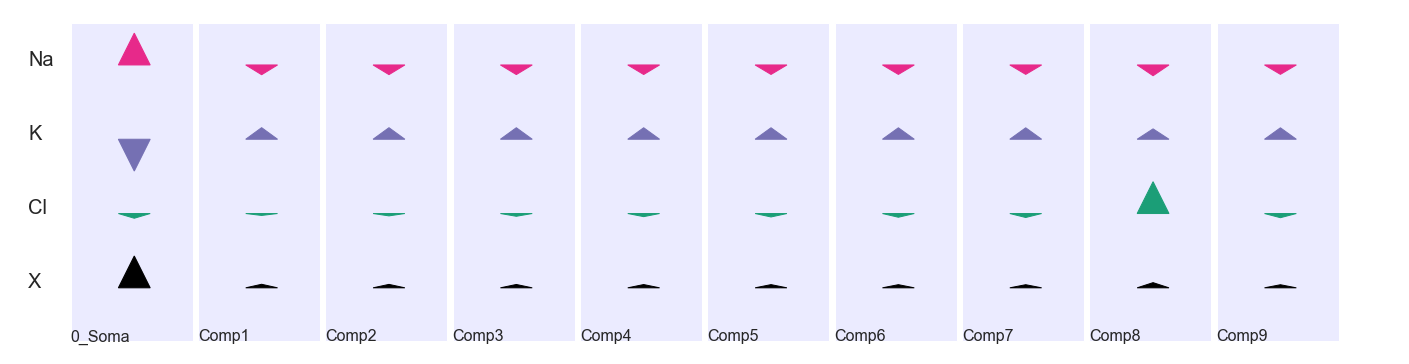

In [63]:
###################################################
btn_overview = widgets.Button(description ="Plot", button_style='success')
rdb_overview_select = widgets.RadioButtons(options=["Absolute concentrations","Fluxes"])
output_overview = widgets.Output(Layout=Layout(border='solid'))
display(rdb_overview_select, btn_overview,output_overview)

def btn_overview_clicked(b):
    
    with output_overview:
        
        f_overview = mplt.figure(figsize=(25,10))
        ax_overview = mplt.gca()
        shapes_arr=[]
        x_val = 5
        y_val = 0

        ax_overview.text(1,y_val+26,"Na", fontsize=20)
        ax_overview.text(1,y_val+19,"K", fontsize=20)
        ax_overview.text(1,y_val+12,"Cl", fontsize=20)
        ax_overview.text(1,y_val+5,"X", fontsize=20)

        if rdb_overview_select.value =="Absolute concentrations":  
            na_unit = df_end["Na_i"].max()
            k_unit = df_end["K_i"].max()
            cl_unit = df_end["Cl_i"].max()
            x_unit = df_end["X_i"].max()


        elif rdb_overview_select.value =="Fluxes":

            df_temp = abs(df_end_net_flux)
            na_unit = abs(df_temp["Na-Net"].max())
            k_unit = abs(df_temp["K-Net"].max())
            cl_unit = abs(df_temp["Cl-Net"].max())
            x_unit = abs(df_temp["X-Net"].max())


        for i in range(len(df_end)):

            comp_rect = mpatches.Rectangle([x_val,y_val],11.5,30, fc='#ebebff')
            shapes_arr.append(comp_rect)
            ax_overview.text(x_val,y_val,df_end.index[i], fontsize=16)

            if rdb_overview_select.value =="Absolute concentrations": 

                na_rad = df_end.iloc[i,3] / na_unit * 4
                na_circle = mpatches.Circle([x_val+6,y_val+28],na_rad, fc='#e7298a',ec='#e7298a')
                shapes_arr.append(na_circle)



                k_rad = df_end.iloc[i,4] / k_unit * 4
                k_circle = mpatches.Circle([x_val+6,y_val+18],na_rad, ec='#7570b3',fc='#7570b3')
                shapes_arr.append(k_circle)

                cl_rad = df_end.iloc[i,5] / cl_unit * 4
                cl_circle = mpatches.Circle([x_val+6,y_val+12],cl_rad, ec='#1b9e77',fc='#1b9e77')
                shapes_arr.append(cl_circle)

                x_rad = df_end.iloc[i,6] / x_unit * 4
                x_circle = mpatches.Circle([x_val+6,y_val+6],x_rad, ec='black',fc='black')
                shapes_arr.append(x_circle)

            if rdb_overview_select.value =="Fluxes": 


                na_rad = df_end_net_flux.iloc[i,0] / na_unit * 3
                na_arrow = mpatches.FancyArrow(x_val+6,y_val+26,0,0,head_width=3,head_length=na_rad, fc='#e7298a',ec='#e7298a')
                shapes_arr.append(na_arrow)

                #FancyArrow(x, y, dx, dy, width=0.001, length_includes_head=False, head_width=None, head_length=None, shape='full', overhang=0, head_starts_at_zero=False, **kwargs)[source]

                k_rad = df_end_net_flux.iloc[i,1] / k_unit * 3
                k_arrow = mpatches.FancyArrow(x_val+6,y_val+19,0,0,head_width=3,head_length=k_rad, ec='#7570b3',fc='#7570b3')
                shapes_arr.append(k_arrow)

                cl_rad = df_end_net_flux.iloc[i,2] / cl_unit * 3
                cl_arrow = mpatches.FancyArrow(x_val+6,y_val+12,0,0,head_width=3,head_length=cl_rad, ec='#1b9e77',fc='#1b9e77')
                shapes_arr.append(cl_arrow)

                x_rad = df_end_net_flux.iloc[i,3] / x_unit * 3
                x_arrow = mpatches.FancyArrow(x_val+6,y_val+5,0,0,head_width=3,head_length=x_rad, ec='black',fc='black')
                shapes_arr.append(x_arrow)


            x_val = x_val + 12








        for j in range(len(shapes_arr)):
            ax_overview.add_patch(shapes_arr[j]) 

        ax_overview.axis("off")
        mplt.axis("Scaled")
       


btn_overview.on_click(btn_overview_clicked)


## C5) Equilibrium-  Transmembrane %flux heatmap

In [64]:
############################################
# GUI SETUP

btn_percent_flux = widgets.Button(description='Plot flux %', button_style='info')

output_percent_flux = widgets.Output()
chk_soma = widgets.Checkbox(value = False, description =" Include soma(comp0)")
hbox_percent_flux = widgets.HBox(children=[btn_percent_flux,chk_soma])

display(hbox_percent_flux, output_percent_flux)

############################################

def btn_percent_flux_clicked(b):
    
    if chk_soma.value == False:
        df = df_end_flux.iloc[1:,]
        temp_comp_arr = comp_names_arr[1:]
    else:
        df = df_end_flux
        temp_comp_arr = comp_names_arr

        
    column_titles = list(df.columns)
    percent_flux_data_arr = []
    
    avg_arr = [ df[column_titles[i]].mean() for i in range(len(column_titles))]
    
    for i in range(len(temp_comp_arr)):
        temp_arr = []
        for j in range(len(column_titles)):
            temp_arr.append(df.iloc[i][j]/avg_arr[j]*100)
        percent_flux_data_arr.append(temp_arr)   
        
        
    
    #Creating figure
    with output_percent_flux:
        
        output_percent_flux.clear_output()
        sns.set(font_scale=2)
        fig_percent_flux_heatmap, ax = mplt.subplots(figsize=(15,10))
        ax = sns.heatmap(percent_flux_data_arr, center=0, cmap="icefire", linewidth=2,cbar_kws={'label':'%'})
        ax.set_xticklabels(column_titles, fontsize=10)
        ax.set_yticklabels(temp_comp_arr, fontsize=10)
        #ax.vlines(x=[0,1,2], ymin=0,ymax=len(comp_names_arr))
        fig_percent_flux_heatmap.suptitle("% change vs average at equilibrium", fontsize=20)
        
        mplt.show()
    
    
btn_percent_flux.on_click(btn_percent_flux_clicked)


Output()

## C6) Equilibrium-  ED %flux heatmap

In [65]:
############################################
# GUI SETUP

btn_percent_edflux = widgets.Button(description='Plot ed flux %', button_style='info')

output_percent_edflux = widgets.Output()


hbox_percent_edflux = widgets.HBox(children=[btn_percent_edflux])

display(hbox_percent_edflux, output_percent_edflux)

############################################

def btn_percent_edflux_clicked(b):
    
   
    df = df_end_ed
    temp_comp_arr = comp_names_arr

    column_titles = list(df.columns)
    row_titles = list(df.index)
    
    percent_flux_data_arr = []
    
    avg_arr = [ df[column_titles[i]].mean() for i in range(len(column_titles))]
    
    for i in range(len(temp_comp_arr)-1):
        temp_arr = []
        for j in range(len(column_titles)):
            temp_arr.append(df.iloc[i][j]/avg_arr[j]*100)
        percent_flux_data_arr.append(temp_arr)   
        
        
    
    #Creating figure
    with output_percent_edflux:
        
        output_percent_edflux.clear_output()
        sns.set(font_scale=2)
        fig_percent_flux_heatmap, ax = mplt.subplots(figsize=(10,15))
        ax = sns.heatmap(percent_flux_data_arr, center=0, cmap="icefire", linewidth=2,cbar_kws={'label':'%'})
        ax.set_xticklabels(column_titles, fontsize=12)
        ax.set_yticklabels(row_titles, fontsize=10)
        #ax.vlines(x=[0,1,2], ymin=0,ymax=len(comp_names_arr))
        fig_percent_flux_heatmap.suptitle("% change vs average at equilibrium", fontsize=20)
        
        mplt.show()
    
    
btn_percent_edflux.on_click(btn_percent_edflux_clicked)


Output()

## C7) Ionic fluxes at equilibrium 

In [66]:
############################################
# GUI SETUP

btn_channel_flux = widgets.Button(description='Plot channel flux ', button_style='info')

output_channel_flux = widgets.Output()
chk_soma2 = widgets.Checkbox(value = False, description =" Include soma(comp0)")

display(chk_soma2, btn_channel_flux, output_channel_flux)

############################################

def btn_channel_flux_clicked(b):
    
    na_df = df_end_flux.iloc[:,1:3]
    k_df = df_end_flux.iloc[:,4:7]
    cl_df = df_end_flux.iloc[:,8:11]
    
    k_ed_arr = []
    cl_ed_arr = []
    na_df["Na_ED"] = -1*df_end_ed.iloc[0,0]
    k_df["K_ED"] = -1*df_end_ed.iloc[0,1]
    cl_df["Cl_ED"] = -1*df_end_ed.iloc[0,2]
    
    na_ed_arr = [-1*df_end_ed.iloc[i,0]+df_end_ed.iloc[i+1,0] for i in range(len(comp_names_arr)-2)] 
    k_ed_arr = [-1*df_end_ed.iloc[i,1]+df_end_ed.iloc[i+1,1] for i in range(len(comp_names_arr)-2)] 
    cl_ed_arr = [-1*df_end_ed.iloc[i,2]+df_end_ed.iloc[i+1,2] for i in range(len(comp_names_arr)-2)] 
    na_df.iloc[1:-1,2] = na_ed_arr[:]
    k_df.iloc[1:-1,3] = k_ed_arr[:]
    cl_df.iloc[1:-1,2] = cl_ed_arr[:]
    na_df.iloc[-1,2] = df_end_ed.iloc[-1,0]
    k_df.iloc[-1,3] = df_end_ed.iloc[-1,1]
    cl_df.iloc[-1,2] = df_end_ed.iloc[-1,2]
    na_df["Na_Nett"] = na_df.sum(axis=1)
    k_df["K_Nett"] = k_df.sum(axis=1)
    cl_df["Cl_Nett"] = cl_df.sum(axis=1)
    
    ion_flux_df = pd.concat([na_df,k_df,cl_df], axis=1)
    
    column_titles = list(ion_flux_df.columns)
    names_arr = comp_names_arr
    
    if chk_soma2.value == False:
        ion_flux_df = ion_flux_df[1:]
        names_arr = names_arr[1:]
    
    #Creating figure
    with output_channel_flux:
        
        output_channel_flux.clear_output()
        sns.set(font_scale=2)
        fig_channel_flux_heatmap, ax = mplt.subplots(figsize=(15,10))
        ax = sns.heatmap(ion_flux_df, center=0, cmap="icefire", linewidth=2,cbar_kws={'label':'Moles'})
        ax.set_xticklabels(column_titles, fontsize=20)
        ax.set_yticklabels(names_arr, fontsize=20)
        #ax.vlines(x=[0,1,2], ymin=0,ymax=len(comp_names_arr))
        fig_channel_flux_heatmap.suptitle("Fluxes at equilibrium", fontsize=20)
        
        mplt.show()
    
    
btn_channel_flux.on_click(btn_channel_flux_clicked)

Checkbox(value=False, description=' Include soma(comp0)')

Button(button_style='info', description='Plot channel flux ', style=ButtonStyle())

Output()

<ipython-input-66-345ea7becd57>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  na_df["Na_ED"] = -1*df_end_ed.iloc[0,0]
<ipython-input-66-345ea7becd57>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_df["K_ED"] = -1*df_end_ed.iloc[0,1]
<ipython-input-66-345ea7becd57>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

## C8) Ion source breakdown

In [67]:
############################################
# GUI SETUP

btn_ion_source = widgets.Button(description='View ion sources ', button_style='info')
drp_comp = widgets.Dropdown(options = comp_names_arr, description = "compartment")

output_ion_source = widgets.Output()


display(drp_comp,btn_ion_source, output_ion_source)

############################################

def btn_ion_source_clicked(b):
    
   
    time_points = [round(t_arr[i*40],2) for i in range(25)]
    time_points = time_points[1:]
     
    na_data, k_data, cl_data =[], [], []
 
    comp = drp_comp.value
    for i in range(len(comp_names_arr)):
        if comp == comp_names_arr[i]:
            comp_num = i
    
    na_atp_arr, na_leak_arr, na_ed_arr = [], [], []
    k_atp_arr, k_leak_arr, k_kcc2_arr,k_ed_arr = [], [],[],[]
    cl_leak_arr, cl_kcc2_arr,cl_ed_arr = [],[],[]
    
  
    
    for i in range(24):
        timepoint = i*40
            
        na_atp_arr.append(master_arr[comp_num][timepoint][11])
        na_leak_arr.append(master_arr[comp_num][timepoint][10])
        
        k_leak_arr.append(master_arr[comp_num][timepoint][13])
        k_atp_arr.append(master_arr[comp_num][timepoint][14])
        k_kcc2_arr.append(master_arr[comp_num][timepoint][15])
        
        cl_leak_arr.append(master_arr[comp_num][timepoint][17])
        cl_kcc2_arr.append(master_arr[comp_num][timepoint][18])
        
        if comp_num == 0:
            na_ed_arr.append(-1*ED_master_arr[comp_num][timepoint][0])
            k_ed_arr.append(-1*ED_master_arr[comp_num][timepoint][1])
            cl_ed_arr.append(-1*ED_master_arr[comp_num][timepoint][2])
        elif comp_num == len(comp_names_arr)-1:
            na_ed_arr.append(ED_master_arr[comp_num-1][timepoint][0])
            k_ed_arr.append(ED_master_arr[comp_num-1][timepoint][1])
            cl_ed_arr.append(ED_master_arr[comp_num-1][timepoint][2])
        else:
            na_ed_arr.append(ED_master_arr[comp_num-1][timepoint][0]-1*ED_master_arr[comp_num][timepoint][0])
            k_ed_arr.append(ED_master_arr[comp_num-1][timepoint][1]-1*ED_master_arr[comp_num][timepoint][1])
            cl_ed_arr.append(ED_master_arr[comp_num-1][timepoint][2]-1*ED_master_arr[comp_num][timepoint][2])
            
            
        #elif: (comp_num != 0) and (comp_num != len(comp_names_arr)):
            
        
    na_data.append(na_atp_arr)
    na_data.append(na_leak_arr)
    na_data.append(na_ed_arr)
    k_data.append(k_atp_arr)
    k_data.append(k_leak_arr)
    k_data.append(k_kcc2_arr)
    k_data.append(k_ed_arr)
    cl_data.append(cl_leak_arr)
    cl_data.append(cl_kcc2_arr)
    cl_data.append(cl_ed_arr)
  
        
        
        
    
    #Creating figure
    with output_ion_source:
        
        output_ion_source.clear_output()
        sns.set(font_scale=2)
        fig_ionsource, (ax1,ax2,ax3) = mplt.subplots(3,1,figsize=(30,20))
        g1 = sns.heatmap(na_data, center=0, cmap="vlag", linewidth=2,cbar_kws={'label':'concentration'},cbar=True,ax=ax1)
        g1.set_xticklabels(time_points, fontsize=20)
        g1.set_yticklabels(["Na ATPase","Na Leak","Na ED"], fontsize=20)
        
        g2 = sns.heatmap(k_data, center=0, cmap="vlag", linewidth=2,cbar_kws={'label':'concentration'}, cbar=True,ax=ax2)
        g2.set_xticklabels(time_points, fontsize=20)
        g2.set_yticklabels(["K ATPase","K Leak ","K KCC2", "K ED"], fontsize=20)
        
        g3 = sns.heatmap(cl_data, center=0, cmap="vlag", linewidth=2,cbar_kws={'label':'concentration'}, cbar=True,ax=ax3)
        g3.set_xticklabels(time_points, fontsize=20)
        g3.set_yticklabels(["Cl leak","Cl KCC2", "Cl ED"], fontsize=20)
        #ax.vlines(x=[0,1,2], ymin=0,ymax=len(comp_names_arr))
        #fig_ionsource.suptitle("Na+ fluxes", fontsize=12)
        fig_ionsource.tight_layout()
        
        mplt.show()
    
    
btn_ion_source.on_click(btn_ion_source_clicked)

Dropdown(description='compartment', options=('0_Soma', 'Comp1', 'Comp2', 'Comp3', 'Comp4', 'Comp5', 'Comp6', '…

Button(button_style='info', description='View ion sources ', style=ButtonStyle())

Output()

IndexError: list index out of range

## C9) Ion breakdown


In [68]:
############################################
# GUI SETUP

btn_ion_break = widgets.Button(description='View ion breakdown ', button_style='info')
drp_ion = widgets.Dropdown(options = ["Na","K","Cl"], description = "Ion")

output_ion_break = widgets.Output()


display(drp_ion,btn_ion_break, output_ion_break)

############################################


time_points = [round(t_arr[i*40],2) for i in range(25)]
time_points = time_points[1:]

def btn_ion_break_clicked(b):
    
    ion = drp_ion.value
    g1_data_arr, g2_data_arr,g3_data_arr, g4_data_arr = [], [],[],[]
    
    for i in range(1,len(comp_names_arr)):
    
        leak_arr = []
        atp_arr = []
        kcc2_arr =[]
        ed_arr = []
        
        
        for j in range(len(time_points)):
            
            timepoint = (j+1)*40
            
            if ion == "Na":
                leak_arr.append(master_arr[i][timepoint][10])
                atp_arr.append(master_arr[i][timepoint][11])
                if i ==0:
                    ed_arr.append(-1*ED_master_arr[i][timepoint][0])
                elif i == len(comp_names_arr)-1:
                    ed_arr.append(ED_master_arr[i-1][timepoint][0])
                else:
                    ed_arr.append(ED_master_arr[i-1][timepoint][0]-1*ED_master_arr[i][timepoint][0])

            elif ion == "K":
                leak_arr.append(master_arr[i][timepoint][13])
                atp_arr.append(master_arr[i][timepoint][14])
                kcc2_arr.append(master_arr[i][timepoint][15])
                if i ==0:
                    ed_arr.append(-1*ED_master_arr[i][timepoint][1])
                elif i == len(comp_names_arr)-1:
                    ed_arr.append(ED_master_arr[i-1][timepoint][1])
                else:
                    ed_arr.append(ED_master_arr[i-1][timepoint][1]-1*ED_master_arr[i][timepoint][1])

            elif ion =="Cl":
                leak_arr.append(master_arr[i][timepoint][17])
                kcc2_arr.append(master_arr[i][timepoint][18])
                if i ==0:
                    ed_arr.append(-1*ED_master_arr[i][timepoint][2])
                elif i == len(comp_names_arr)-1:
                    ed_arr.append(ED_master_arr[i-1][timepoint][2])
                else:
                    ed_arr.append(ED_master_arr[i-1][timepoint][2]-1*ED_master_arr[i][timepoint][2])
        
        g1_data_arr.append(leak_arr)
        g2_data_arr.append(atp_arr)
        g3_data_arr.append(kcc2_arr)
        g4_data_arr.append(ed_arr)
        
    
         #Creating figure
    with output_ion_break:

        output_ion_break.clear_output()
        sns.set(font_scale=2)
        if ion =="Na":
            fig_ionbreak, (ax1,ax2,ax3) = mplt.subplots(3,1,figsize=(30,40))
            g1 = sns.heatmap(g1_data_arr, center=np.mean(g1_data_arr), cmap="mako", linewidth=2,cbar_kws={'label':'concentration'},cbar=True,ax=ax1)
            g1.set_xticklabels(time_points, fontsize=20)
            g1.set_ylabel("Na_Leak",fontsize=40)
            g1.set_yticklabels(comp_names_arr[1:], fontsize=20)

            g2 = sns.heatmap(g2_data_arr, center=np.mean(g2_data_arr), cmap="mako", linewidth=2,cbar_kws={'label':'concentration'}, cbar=True,ax=ax2)
            g2.set_xticklabels(time_points, fontsize=20)
            g2.set_ylabel("Na_ATPase",fontsize=40)
            g2.set_yticklabels(comp_names_arr[1:], fontsize=20)
            
            g4 = sns.heatmap(g4_data_arr, center=np.mean(g4_data_arr), cmap="mako", linewidth=2,cbar_kws={'label':'concentration'}, cbar=True,ax=ax3)
            g4.set_xticklabels(time_points, fontsize=20)
            g4.set_ylabel("Na_ED",fontsize=40)
            g4.set_yticklabels(comp_names_arr[1:], fontsize=20)

                #g3 = sns.heatmap(cl_data, center=0, cmap="vlag", linewidth=2,cbar_kws={'label':'concentration'}, cbar=True,ax=ax3)
                #g3.set_xticklabels(time_points, fontsize=20)
                #g3.set_yticklabels(comp_names_arr, fontsize=20)
                #ax.vlines(x=[0,1,2], ymin=0,ymax=len(comp_names_arr))
                #fig_ionsource.suptitle("Na+ fluxes", fontsize=12)
                
        if ion =="K": 
            fig_ionbreak, (ax1,ax2,ax3,ax4) = mplt.subplots(4,1,figsize=(30,40))
            g1 = sns.heatmap(g1_data_arr, center=np.mean(g1_data_arr), cmap="icefire", linewidth=2,cbar_kws={'label':'concentration'},cbar=True,ax=ax1)
            g1.set_xticklabels(time_points, fontsize=20)
            g1.set_ylabel("K_Leak",fontsize=40)
            g1.set_yticklabels(comp_names_arr[1:], fontsize=20)

            g2 = sns.heatmap(g2_data_arr, center=np.mean(g2_data_arr), cmap="icefire", linewidth=2,cbar_kws={'label':'concentration'}, cbar=True,ax=ax2)
            g2.set_xticklabels(time_points, fontsize=20)
            g2.set_ylabel("K_ATPase",fontsize=40)
            g2.set_yticklabels(comp_names_arr[1:], fontsize=20)
            
            g3 = sns.heatmap(g3_data_arr, center=np.mean(g3_data_arr), cmap="icefire", linewidth=2,cbar_kws={'label':'concentration'}, cbar=True,ax=ax3)
            g3.set_xticklabels(time_points, fontsize=20)
            g3.set_ylabel("K_KCC2",fontsize=40)
            g3.set_yticklabels(comp_names_arr[1:], fontsize=20)
            
            g4 = sns.heatmap(g4_data_arr, center=np.mean(g4_data_arr), cmap="icefire", linewidth=2,cbar_kws={'label':'concentration'}, cbar=True,ax=ax4)
            g4.set_xticklabels(time_points, fontsize=20)
            g4.set_ylabel("K_ED",fontsize=40)
            g4.set_yticklabels(comp_names_arr[1:], fontsize=20)
                
        if ion =="Cl":
            fig_ionbreak, (ax1,ax2,ax3) = mplt.subplots(3,1,figsize=(30,40))
            g1 = sns.heatmap(g1_data_arr, center=np.mean(g1_data_arr), cmap="icefire", linewidth=2,cbar_kws={'label':'concentration'},cbar=True,ax=ax1)
            g1.set_xticklabels(time_points, fontsize=20)
            g1.set_ylabel("Cl_Leak",fontsize=40)
            g1.set_yticklabels(comp_names_arr[1:], fontsize=20)

            g3 = sns.heatmap(g3_data_arr, center=np.mean(g3_data_arr), cmap="icefire", linewidth=2,cbar_kws={'label':'concentration'}, cbar=True,ax=ax2)
            g3.set_xticklabels(time_points, fontsize=20)
            g3.set_ylabel("Cl_KCC2",fontsize=40)
            g3.set_yticklabels(comp_names_arr[1:], fontsize=20)
            
            g4 = sns.heatmap(g4_data_arr, center=np.mean(g4_data_arr), cmap="icefire", linewidth=2,cbar_kws={'label':'concentration'}, cbar=True,ax=ax3)
            g4.set_xticklabels(time_points, fontsize=20)
            g4.set_ylabel("Cl_ED",fontsize=40)
            g4.set_yticklabels(comp_names_arr[1:], fontsize=20)
                
        fig_ionbreak.tight_layout()

        mplt.show()
        
btn_ion_break.on_click(btn_ion_break_clicked)

Dropdown(description='Ion', options=('Na', 'K', 'Cl'), value='Na')

Button(button_style='info', description='View ion breakdown ', style=ButtonStyle())

Output()

IndexError: list index out of range

### Simulation end values 

In [15]:
df_end

,Radius,Length,Volume,Na_i,K_i,Cl_i,X_i,z_i,Vm (mV),Ek (mV),ECl (mV),Cl-Driving force (mV)
Comp1,0.000005,0.0001,7.853513e-15,0.013993,0.122853,0.005172,0.154982,-0.85,-72.580269,-95.099390,-83.812871,11.232602
Comp2,0.000005,0.0001,7.853513e-15,0.013993,0.122853,0.005172,0.154982,-0.85,-72.580269,-95.099390,-83.812874,11.232605
Comp3,0.000005,0.0001,7.853513e-15,0.013993,0.122853,0.005172,0.154982,-0.85,-72.580270,-95.099389,-83.812880,11.232610
Comp4,0.000005,0.0001,7.853512e-15,0.013993,0.122853,0.005172,0.154982,-0.85,-72.580270,-95.099387,-83.812884,11.232614
Comp5,0.000005,0.0001,7.853512e-15,0.013993,0.122853,0.005172,0.154982,-0.85,-72.580271,-95.099385,-83.812884,11.232613
Comp6,0.000005,0.0001,7.853511e-15,0.013993,0.122853,0.005172,0.154982,-0.85,-72.580271,-95.099383,-83.812873,11.232602
Comp7,0.000005,0.0001,7.853511e-15,0.013993,0.122853,0.005172,0.154982,-0.85,-72.580271,-95.099381,-83.812846,11.232575
Comp8,0.000005,0.0001,7.853511e-15,0.013993,0.122853,0.005172,0.154982,-0.85,-72.580270,-95.099379,-83.812795,11.232525
Comp9,0.000005,0.0001,7.853511e-15,0.013994,0.122853,0.005172,0.154982,-0.85,-72.580267,-95.099377,-83.812712,11.232445
Soma,0.000010,0.0002,6.283445e-14,0.013995,0.122867,0.005171,0.154966,-0.85,-72.583418,-95.102532,-83.815685,11.232266


### Transmembrane fluxes


In [16]:
df_end_flux

,Na_net,Na_leak,Na_Atpase,K_net,K_leak,K_Atpase,K_kcc2,Cl_net,Cl_leak,Cl_kcc2
Comp1,4.040008e-28,8.795655e-24,-8.795251e-24,-3.917040e-27,-5.132455e-24,5.863501e-24,-7.349633e-25,-3.511085e-27,7.314522e-25,-7.349633e-25
Comp2,4.034372e-28,8.795655e-24,-8.795251e-24,-3.916592e-27,-5.132454e-24,5.863501e-24,-7.349631e-25,-3.510610e-27,7.314524e-25,-7.349631e-25
Comp3,4.023355e-28,8.795653e-24,-8.795251e-24,-3.915813e-27,-5.132454e-24,5.863501e-24,-7.349626e-25,-3.509847e-27,7.314528e-25,-7.349626e-25
Comp4,4.007457e-28,8.795651e-24,-8.795251e-24,-3.914936e-27,-5.132453e-24,5.863500e-24,-7.349622e-25,-3.509170e-27,7.314530e-25,-7.349622e-25
Comp5,3.987405e-28,8.795649e-24,-8.795250e-24,-3.914302e-27,-5.132453e-24,5.863500e-24,-7.349621e-25,-3.509118e-27,7.314529e-25,-7.349621e-25
Comp6,3.964131e-28,8.795647e-24,-8.795250e-24,-3.914344e-27,-5.132452e-24,5.863500e-24,-7.349626e-25,-3.510385e-27,7.314522e-25,-7.349626e-25
Comp7,3.938734e-28,8.795644e-24,-8.795250e-24,-3.915577e-27,-5.132451e-24,5.863500e-24,-7.349642e-25,-3.513793e-27,7.314504e-25,-7.349642e-25
Comp8,3.912444e-28,8.795641e-24,-8.795250e-24,-3.918579e-27,-5.132451e-24,5.863500e-24,-7.349674e-25,-3.520266e-27,7.314472e-25,-7.349674e-25
Comp9,3.886581e-28,8.795639e-24,-8.795250e-24,-3.923972e-27,-5.132451e-24,5.863500e-24,-7.349727e-25,-3.530798e-27,7.314419e-25,-7.349727e-25
Soma,1.540265e-27,3.518432e-23,-3.518278e-23,-1.574726e-26,-2.053085e-23,2.345519e-23,-2.940087e-24,-1.421765e-26,2.925869e-24,-2.940087e-24


### Electrodiffusion fluxes

In [17]:

print("Positive Values --> ion leaving compA to enter compB")
print("Negative Values --> ion leaving compB to enter compA")
df_end_ed

Positive Values --> ion leaving compA to enter compB
Negative Values --> ion leaving compB to enter compA


,Na_ED_flux,K_ED_flux,Cl_ED_flux
Comp1 <- Comp2,3.729098e-46,-4.544715e-46,-8.185367e-47
Comp2 <- Comp3,7.289890e-46,-8.575047e-46,-1.295858e-46
Comp3 <- Comp4,1.052000e-45,-1.159504e-45,-1.102018e-46
Comp4 <- Comp5,1.326877e-45,-1.314345e-45,7.027110e-48
Comp5 <- Comp6,1.540230e-45,-1.281331e-45,2.495713e-46
Comp6 <- Comp7,1.680860e-45,-1.026097e-45,6.407134e-46
Comp7 <- Comp8,1.740119e-45,-5.221832e-46,1.198806e-45
Comp8 <- Comp9,1.712201e-45,2.479360e-46,1.936689e-45
Comp9 <- Soma,1.594389e-45,1.292801e-45,2.861274e-45


### Net flux


In [15]:
df_end_net_flux

,Na-Net,K-Net,Cl-Net,X-Net,Total
Comp0_Soma,-6.877822e-28,6.931129e-28,-2.378720e-30,4.847866e-26,-4.847095e-26
Comp1,-1.718271e-28,1.732313e-28,-6.048095e-31,5.443732e-27,-5.441723e-27
Comp2,-1.713075e-28,1.730502e-28,-6.557395e-31,5.276691e-27,-5.274292e-27
Comp3,-1.708532e-28,1.728917e-28,-7.036179e-31,5.130160e-27,-5.127418e-27
Comp4,-1.892669e-28,1.469202e-28,9.157474e-30,1.409103e-27,-1.460607e-27
Comp5,-1.701860e-28,1.726599e-28,-7.515177e-31,4.901784e-27,-4.898559e-27
Comp6,-1.699283e-28,1.725713e-28,-7.533188e-31,4.816982e-27,-4.813586e-27
Comp7,-1.697353e-28,1.725050e-28,-7.524846e-31,4.756437e-27,-4.752915e-27
Comp8,-1.710366e-28,1.841788e-28,-3.037871e-30,-5.388117e-27,5.404297e-27
Comp9,-1.695427e-28,1.724387e-28,-7.519676e-31,4.696089e-27,-4.692441e-27


# D) Fluxes


Dropdown(options=('Na', 'K', 'Cl', 'X'), value='Na')

Button(button_style='success', description='Plot', style=ButtonStyle())

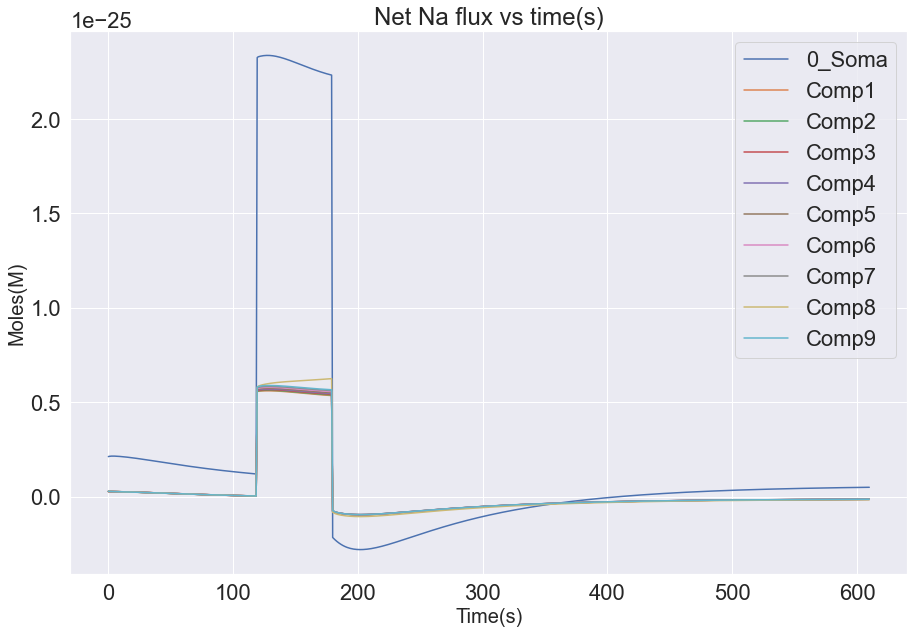

In [69]:
##############################################
drp_ion = widgets.Dropdown(options =['Na','K','Cl','X'])
btn_plot_flux = widgets.Button(description="Plot", button_style = 'success')
display(drp_ion,btn_plot_flux)
output_flux = widgets.Output()

#################################################

def btn_plot_flux_clicked(b):
    
    ion_dict = {'Na':9,'K':12,'Cl':16,'X':0}
    ion_dict_ed = {'Na':0,'K':1,'Cl':2,'X':0}
    ion_index = ion_dict[drp_ion.value]
    ion_index_ed = ion_dict_ed[drp_ion.value]
    flux_arr = []    
    
    
    if drp_ion.value != 'X':
        
        for i in range(len(comp_names_arr)):
            temp_arr = []
            for j in range(1,len(t_arr)-2):
                ed_flux_r,ed_flux_l = 0,0
                membr_flux = master_arr[i][j][ion_index] * master_arr[i][j][3]
                if i != 9:
                    ed_flux_r = ED_master_arr[i][j][ion_index_ed]*-1
                if i != 0:
                    ed_flux_l = ED_master_arr[i-1][j][ion_index_ed]
                net_flux = membr_flux + ed_flux_r + ed_flux_l
                temp_arr.append(net_flux)
            flux_arr.append(temp_arr)    
            
    elif drp_ion.value == 'X':
        for i in range(len(comp_names_arr)):
            temp_arr = []
            for j in range(1,len(t_arr)-2):
                last_x = master_arr[i][j][7] * master_arr[i][j][3]
                secondlast_x = master_arr[i][j-1][7] * master_arr[i][j-1][3]
                x_flux = last_x - secondlast_x
                temp_arr.append(x_flux)
            flux_arr.append(temp_arr)
    output_flux.clear_output()        
    
   
    
        
        
    fig_flux, ax = mplt.subplots(figsize=(15,10))
    
    for k in range(len(flux_arr)):
        ax.plot(t_arr[0:-3],flux_arr[k],label=comp_names_arr[k])

    ax.set_xlabel('Time(s)', fontsize=20)
    ax.set_ylabel('Moles(M)', fontsize=20)
    ax.set_title('Net ' + drp_ion.value + ' flux vs time(s)')
    ax.legend() 
        
        #sns.despine()
        #mplt.show()


###############################################

btn_plot_flux.on_click(btn_plot_flux_clicked)

# E) Heatmaps

In [70]:

# Make the same graph as above but with absolute changes

############################################
# GUI SETUP

btn_potentials = widgets.Button(description='Compare voltages', button_style='info')
sldr_potentials = widgets.IntSlider(description='Interval', min = 2, max=len(interval_arr), value=len(interval_arr))
output_potentials = widgets.Output()
hbox_potentials = widgets.HBox(children=[btn_potentials,sldr_potentials])

display(hbox_potentials, output_potentials)

############################################

def btn_potentials_clicked(b):
    
    heatmap_arr =[]
    interval = sldr_potentials.value-1
    
    #Heatmap data
    for i in range(len(comp_names_arr)-1,-1,-1):
        temp_arr = [] #holds values for a particular compartment
        abs_vm =  master_arr[i][interval][-3]*1e3 - master_arr[i][2][-3]*1e3
        temp_arr.append(abs_vm) #Vm
        abs_ecl =   master_arr[i][interval][-1]*1e3 - master_arr[i][2][-1]*1e3
        temp_arr.append(abs_ecl) #ECl
        abs_drf_cl =  (master_arr[i][interval][-3]-master_arr[i][interval][-1])*1e3 - (master_arr[i][2][-3]-master_arr[i][2][-1])*1e3
        temp_arr.append(abs_drf_cl) #Cl Driving Force
        heatmap_arr.append(temp_arr)
    
    
    #Creating figure
    with output_potentials:
        
        output_potentials.clear_output()
        sns.set(font_scale=2)
        fig_heatmap, ax = mplt.subplots(figsize=(15,10))
        ax = sns.heatmap(heatmap_arr, center=0, cmap="icefire", linewidth=2,cbar_kws={'label':'mV'})
        ax.set_xticklabels(['Vm','ECl','Cl driving force'], fontsize=20)
        ax.set_yticklabels(comp_names_arr[::-1], fontsize=12, rotation=0)
        ax.vlines(x=[0,1,2], ymin=0,ymax=len(comp_names_arr))
        fig_heatmap.suptitle("Absolute Voltage changes at specific interval", fontsize=20)
        
        mplt.show()
    
    
    
btn_potentials.on_click(btn_potentials_clicked)

Output()

IndexError: list index out of range

# F) Axial voltages

v_bound = v_mem_comp_a - v_mem_comp_b

e_cl_bound = (R * T / F) * log( cl_conc_comp_a / cl_conc_comp_b )

df_cl_bound = v_bound - e_cl_bound

In [77]:
########
# Function to calculate all the axial voltages during the simulation
global v_bound_arr, e_cl_bound_arr, df_cl_bound_arr
v_bound_arr, e_cl_bound_arr, df_cl_bound_arr = [],[],[]
global RTF
R = 8.31446
F = 96485.33  # Faraday's constant        C mol-1
T = 37 + 273.15
RTF = R * T / F

global t_points_arr,x_ax_labels
num_bins = 25
#t_bins = round(len(interval_arr)/num_bins)
t_bins = round(len(master_arr[0])/num_bins)
t_points_arr = [i*t_bins for i in range(num_bins) ]
x_ax_labels = [round(t_arr[i*t_bins],1) for i in range(num_bins-1)]
print(len(master_arr[0]))

def calc_axial_voltages():
     
    
    for i in range(len(comp_names_arr)-1):
        
        temp_arr_1, temp_arr_2, temp_arr_3 = [],[],[]
    
        for t in range(len(t_points_arr)-1):
            
            time_point = t_points_arr[t]
            

            v_bound = master_arr[i][time_point][-3] - master_arr[i+1][time_point][-3]
            temp_arr_1.append(v_bound*1e3)
            
            e_cl_bound = RTF * np.log(master_arr[i][time_point][6] / master_arr[i+1][time_point][6])
            temp_arr_2.append(e_cl_bound*1e3)
            
            df_cl_bound = v_bound - e_cl_bound
            temp_arr_3.append(df_cl_bound*1e3)
        
        v_bound_arr.append(temp_arr_1)
        e_cl_bound_arr.append(temp_arr_2)
        df_cl_bound_arr.append(temp_arr_3)
        

        
    return print("Axial voltages loaded into arrays and ready for plotting")
    

calc_axial_voltages()



730
Axial voltages loaded into arrays and ready for plotting


### Plot axial voltages

Button(button_style='info', description='plot axial voltages ', style=ButtonStyle())

Output()

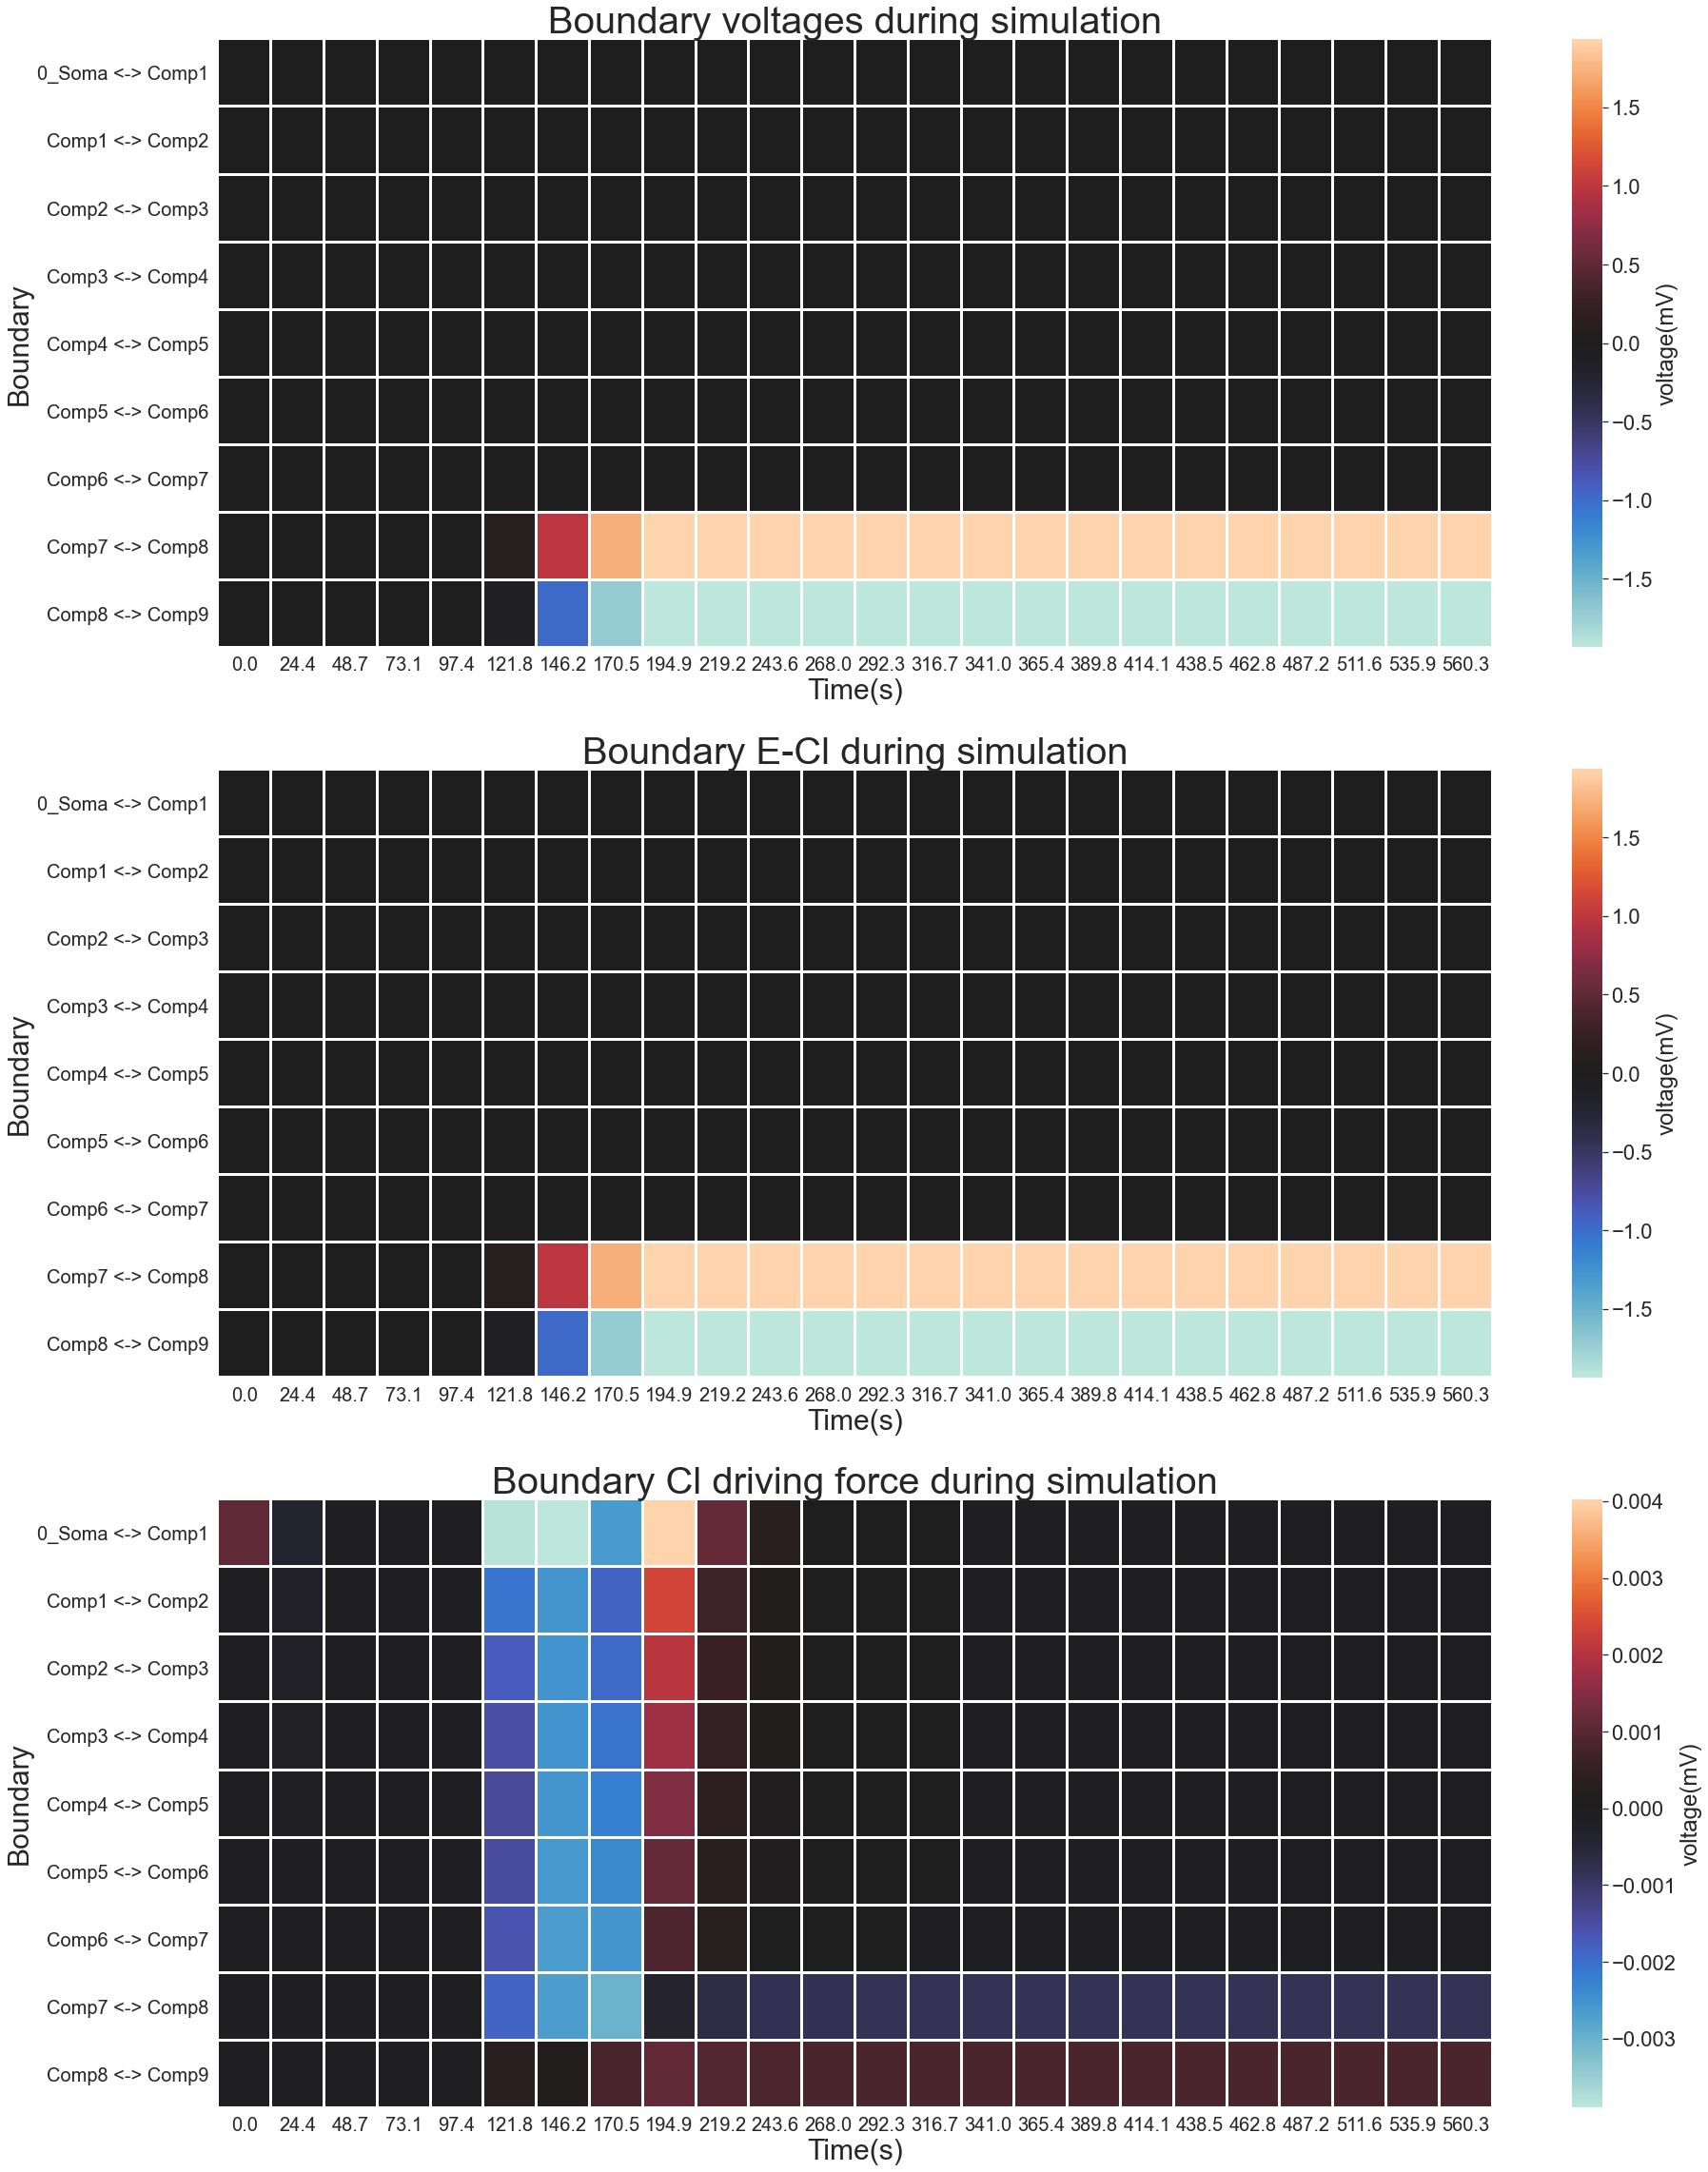

In [78]:
#######################################
# GUI

btn_axial_voltages = widgets.Button(description='plot axial voltages ', button_style='info')
output_axial_voltages = widgets.Output()
display(btn_axial_voltages, output_axial_voltages)

######################################
bound_names_arr = [comp_names_arr[i] + ' <-> ' + comp_names_arr[i+1] for i in range(len(comp_names_arr)-1)]


def btn_axial_voltages_clicked(b):
    
    f_axial_voltages, (ax_v_bound, ax_e_cl_bound, ax_df_cl_bound) = mplt.subplots(3 , 1 , figsize=( 30 , 40 ))

    
    g_v_bound = sns.heatmap(v_bound_arr,cmap="icefire", linewidth=2,cbar_kws={'label':'voltage(mV)'},cbar=True,ax=ax_v_bound)
    g_v_bound.set_yticklabels(bound_names_arr, fontsize=20, rotation=0)
    g_v_bound.set_xticklabels(x_ax_labels, fontsize=20)
    g_v_bound.set_title("Boundary voltages during simulation", fontsize=40)
    g_v_bound.set_xlabel("Time(s)", fontsize=30)
    g_v_bound.set_ylabel("Boundary", fontsize=30)
 
    g_e_cl_bound = sns.heatmap(e_cl_bound_arr,cmap="icefire", linewidth=2,cbar_kws={'label':'voltage(mV)'},cbar=True,ax=ax_e_cl_bound)
    g_e_cl_bound.set_yticklabels(bound_names_arr, fontsize=20, rotation=0)
    g_e_cl_bound.set_xticklabels(x_ax_labels, fontsize=20)
    g_e_cl_bound.set_title("Boundary E-Cl during simulation", fontsize=40)
    g_e_cl_bound.set_xlabel("Time(s)", fontsize=30)
    g_e_cl_bound.set_ylabel("Boundary", fontsize=30)
    
    g_df_cl_bound = sns.heatmap(df_cl_bound_arr,cmap="icefire", linewidth=2,cbar_kws={'label':'voltage(mV)'},cbar=True,ax=ax_df_cl_bound)
    g_df_cl_bound.set_yticklabels(bound_names_arr, fontsize=20, rotation=0)
    g_df_cl_bound.set_xticklabels(x_ax_labels, fontsize=20)
    g_df_cl_bound.set_title("Boundary Cl driving force during simulation", fontsize=40)
    g_df_cl_bound.set_xlabel("Time(s)", fontsize=30)
    g_df_cl_bound.set_ylabel("Boundary", fontsize=30)
                   
    
    
    mplt.show()
    

######################################
btn_axial_voltages.on_click(btn_axial_voltages_clicked)